In [1]:
!python --version

Python 3.9.0


In [3]:
import pandas as pd
from besos import eppy_funcs as ef, sampling
from besos.evaluator import EvaluatorEP
from besos.optimizer import NSGAII, df_solution_to_solutions
# from besos.parameters import RangeParameter, expand_plist, wwr, FieldSelector, CategoryParameter
from besos.parameters import wwr, RangeParameter, FieldSelector, FilterSelector, GenericSelector, Parameter, expand_plist, CategoryParameter

from besos.problem import EPProblem
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from platypus import Archive, Hypervolume, Solution

# from eppy.modeleditor import IDF
import os
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

AttributeError: module 'matplotlib.cm' has no attribute 'register_cmap'

In [3]:
idf_path = 'data/office/Office_IDF_2_win_96.idf'
epw_path = "D:/Categorized/polito/S3/ICT_in_Building_Design/Project/IDF-optimization/data/weather/FRA_Paris.Orly.071490_IWEC.epw"

In [4]:
building = ef.get_building(idf_path)

In [4]:
# building.view_model()

In [15]:
for key in building.idfobjects.keys():
    print(f"'{key}'")
    print(building.idfobjects[key])

'VERSION'
[
Version,
    9.6;                      !- Version Identifier
]
'SIMULATIONCONTROL'
[
SimulationControl,
    Yes,                      !- Do Zone Sizing Calculation
    Yes,                      !- Do System Sizing Calculation
    No,                       !- Do Plant Sizing Calculation
    No,                       !- Run Simulation for Sizing Periods
    Yes,                      !- Run Simulation for Weather File Run Periods
    ,                         !- Do HVAC Sizing Simulation for Sizing Periods
    ;                         !- Maximum Number of HVAC Sizing Simulation Passes
]
'PERFORMANCEPRECISIONTRADEOFFS'
[]
'BUILDING'
[
Building,
    Building,                 !- Name
    0,                        !- North Axis
    Suburbs,                  !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.4,                      !- Temperature Convergence Tolerance Value
    FullExterior,             !- Solar Distribution
    25,                

### Wall and roof Insulation params

In [5]:
roof_ins = FieldSelector(
    class_name='Material',
    object_name='_InsulationEX_Roof_.01',
    field_name='Thickness'
)
roof_range = RangeParameter(min_val=0.1,max_val=0.5)

wall_ins = FieldSelector(
    class_name='Material', 
    object_name='_InsulationEX_.01', 
    field_name='Thickness'
)
wall_range = RangeParameter(min_val=0.1,max_val=0.5)

insulation_param = [
    Parameter(selector=wall_ins,
             value_descriptors=wall_range,
             name='Wall Insulation'),
    Parameter(selector=roof_ins,
             value_descriptors=roof_range,
             name='Roof Insulation')
]

### Window and shading params 

In [27]:
building.idfobjects["fenestrationsurface:detailed"]

[
FenestrationSurface:Detailed,
    Block1:OfficeXSWX1f_Partition_3_0_0_0_0_0_Door,    !- Name
    Door,                     !- Surface Type
    Project internal door,    !- Construction Name
    Block1:OfficeXSWX1f_Partition_3_0_0,    !- Building Surface Name
    Block1:CorridorX1f_Partition_6_0_0_0_0_0_Door_10005,    !- Outside Boundary Condition Object
    0,                        !- View Factor to Ground
    ,                         !- Frame and Divider Name
    1,                        !- Multiplier
    4,                        !- Number of Vertices
    -4.52673915,              !- Vertex 1 Xcoordinate
    -3.0151963605,            !- Vertex 1 Ycoordinate
    3.6,                      !- Vertex 1 Zcoordinate
    -5.42673915,              !- Vertex 2 Xcoordinate
    -3.0151963605,            !- Vertex 2 Ycoordinate
    3.6,                      !- Vertex 2 Zcoordinate
    -5.42673915,              !- Vertex 3 Xcoordinate
    -3.0151963605,            !- Vertex 3 Ycoordinate
   

In [28]:
building.idfobjects["windowshadingcontrol"]

[
WindowShadingControl,
    11001,                    !- Name
    Block1:OfficeXSWX1f,      !- Zone Name
    ,                         !- Shading Control Sequence Number
    InteriorBlind,            !- Shading Type
    Sgl Clr 6mm - 2001,       !- Construction with Shading Name
    OnIfHighOutdoorAirTempAndHighHorizontalSolar,    !- Shading Control Type
    On 24/7,                  !- Schedule Name
    24,                       !- Setpoint
    Yes,                      !- Shading Control Is Scheduled
    No,                       !- Glare Control Is Active
    ,                         !- Shading Device Material Name
    FixedSlatAngle,           !- Type of Slat Angle Control for Blinds
    ,                         !- Slat Angle Schedule Name
    120,                      !- Setpoint 2
    ,                         !- Daylighting Control Object Name
    Group,                    !- Multiple Surface Control Type
    Block1:OfficeXSWX1f_Wall_5_0_0_0_0_0_Win;    !- Fenestration Surface

In [9]:
def window_obj_filter(building):
    return [obj for obj in building.idfobjects["fenestrationsurface:detailed"] if "Win" in obj.Name]

window_objects = window_obj_filter(building)
windows_sel = FilterSelector(window_objects, field_name="Construction Name")

In [6]:
windows_range = CategoryParameter([
    "Sgl Clr 6mm - 1001",
    "Sgl Clr 6mm - 2001",
    "Dbl LoE (e2=.1) Clr 6mm/13 mm Arg - 1003",
    "Dbl LoE (e2=.1) Clr 6mm/13mm Arg - 2003",
    "Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 1002",
    "Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 2002"
])

windows_param = Parameter(
    selector=windows_sel,
    value_descriptors=windows_range,
    name="Windows Type"
)

In [167]:
for sample in range(samples.shape[0]):
    print(samples["Windows Type"].values[sample])
    

Sgl Clr 6mm - 1001
Dbl LoE (e2=.1) Clr 6mm/13 mm Arg - 1003
Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 2002


In [162]:
# def WindowShadingControl_filter(building):
#     return [obj for obj in building.idfobjects["windowshadingcontrol"]]

# window_shading_control_objects = building.idfobjects["windowshadingcontrol"]
# window_shading_control_sel = FieldSelector(window_shading_control_objects, field_name="Construction with Shading Name")

In [158]:
# window_shading_control_sel.set(building, "Dbl LoE (e2=.1) Clr 6mm/13 mm Arg - 1003")

In [163]:
# window_shading_control_sel

In [15]:
window_shading_control_sel = FieldSelector(class_name="*", object_name='windowshadingcontrol', field_name='Construction with Shading Name')
windows_range = CategoryParameter([
    "Sgl Clr 6mm - 1001",
    "Sgl Clr 6mm - 2001",
    "Dbl LoE (e2=.1) Clr 6mm/13 mm Arg - 1003",
    "Dbl LoE (e2=.1) Clr 6mm/13mm Arg - 2003",
    "Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 1002",
    "Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 2002"
])

windows_shading_control_param = Parameter(
    selector=window_shading_control_sel,
    value_descriptors=windows_range,
    name="Windows Shading Type"
)

In [65]:
# # Custom FieldSelector for Windows
# class WindowFieldSelector(FieldSelector):
#     """Custom FieldSelector to filter FenestrationSurface:Detailed objects with Surface_Type == 'Window'."""
#     def get_objects(self, building):
#         objects = super().get_objects(building)
#         return [obj for obj in objects if getattr(obj, "Surface_Type", "").lower() == "window"]

# class ShadingControlSelector(FieldSelector):
#     """Custom FieldSelector to synchronize shading constructions."""
#     def __init__(self, *args, windows_mapping=None, shaded_constructions=None, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.windows_mapping = windows_mapping
#         self.shaded_constructions = shaded_constructions  # List of valid shaded constructions

#     def set(self, building, value):
#         """
#         Update the Construction with Shading Name for each shading control object
#         based on the current Construction Name in FenestrationSurface:Detailed.
#         """
#         shading_objects = super().get_objects(building)
#         for shading_obj in shading_objects:
#             # Find the corresponding window object
#             window_name = getattr(shading_obj, "Fenestration_Surface_1_Name", None)
#             if not window_name:
#                 continue
#             window_obj = next(
#                 (win for win in self.windows_mapping if win.Name == window_name), None
#             )
#             if window_obj:
#                 # Ensure valid mapping of unshaded to shaded constructions
#                 unshaded_construction = window_obj.Construction_Name
#                 shaded_construction = self.shaded_constructions.get(unshaded_construction)
#                 if shaded_construction:
#                     shading_obj.Construction_with_Shading_Name = shaded_construction
#                 else:
#                     raise ValueError(
#                         f"No valid shaded construction found for {unshaded_construction}"
#                     )

# # Example mapping of unshaded to shaded constructions
# shaded_constructions_map = {
#     "Sgl Clr 6mm - 1001": "Sgl Clr 6mm - 2001",
#     "Dbl LoE (e2=.1) Clr 6mm/13 mm Arg - 1003": "Dbl LoE (e2=.1) Clr 6mm/13mm Arg - 2003",
#     "Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 1002": "Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 2002",
# }

# # Update selector
# shading_sel = ShadingControlSelector(
#     class_name="WindowShadingControl",
#     object_name="*",
#     field_name="Construction with Shading Name",
#     windows_mapping=windows_sel.get_objects(building),  # Pass the window objects
#     shaded_constructions=shaded_constructions_map,     # Pass the mapping
# )

# # Define selectors and parameters
# windows_sel = WindowFieldSelector(
#     class_name="FenestrationSurface:Detailed",
#     object_name="*",  # Matches all objects in the class
#     field_name="Construction Name",
# )

# # shading_sel = ShadingControlSelector(
# #     class_name="WindowShadingControl",
# #     object_name="*",  # Matches all shading objects
# #     field_name="Construction with Shading Name",
# # )

# # Define value range
# windows_range = CategoryParameter([
#     "Sgl Clr 6mm - 1001",
#     "Sgl Clr 6mm - 2001",
#     "Dbl LoE (e2=.1) Clr 6mm/13 mm Arg - 1003",
#     "Dbl LoE (e2=.1) Clr 6mm/13mm Arg - 2003",
#     "Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 1002",
#     "Trp LoE (e2=e5=.1) Clr 3mm/13mm Arg - 2002"
# ])

# # Parameters for windows and shading controls
# windows_param = Parameter(
#     selector=windows_sel,
#     value_descriptors=windows_range,
#     name="Windows Type"
# )

# shading_param = Parameter(
#     selector=shading_sel,
#     value_descriptors=windows_range,  # Same categories as windows
#     name="Shading Type"
# )

# # Add parameters to optimization problem
# parameters = [windows_param]

### Ventilations params

In [18]:
for obj in building.idfobjects["ZoneVentilation:DesignFlowRate"]:
    print(obj)


ZoneVentilation:DesignFlowRate,
    Block1:OfficeXSWX1f Nat Vent,    !- Name
    Block1:OfficeXSWX1f,      !- Zone or ZoneList Name
    _Summer_Ventilation,      !- Schedule Name
    Flow/zone,                !- Design Flow Rate Calculation Method
    0.342611,                 !- Design Flow Rate
    ,                         !- Flow Rate per Zone Floor Area
    ,                         !- Flow Rate per Person
    ,                         !- Air Changes per Hour
    NATURAL,                  !- Ventilation Type
    0,                        !- Fan Pressure Rise
    1,                        !- Fan Total Efficiency
    1,                        !- Constant Term Coefficient
    0,                        !- Temperature Term Coefficient
    0,                        !- Velocity Term Coefficient
    0,                        !- Velocity Squared Term Coefficient
    24,                       !- Minimum Indoor Temperature
    ,                         !- Minimum Indoor Temperature Schedule

In [6]:
ventilation_minimum_sel = FieldSelector(
    class_name='ZoneVentilation:DesignFlowRate',
    object_name='*',
    field_name='Minimum Indoor Temperature'
)

ventilation_maximum_sel = FieldSelector(
    class_name='ZoneVentilation:DesignFlowRate',
    object_name='*',
    field_name='Maximum Outdoor Temperature'
)

min_in_temp_range = RangeParameter(min_val=20, max_val=26)
max_out_temp_range = RangeParameter(min_val=26, max_val=30)

ventilation_min_param = Parameter(
    selector=ventilation_minimum_sel,
    value_descriptors=min_in_temp_range,
    name="Ventilation Minimum Indoor Temperature"
)
ventilation_max_param = Parameter(
    selector=ventilation_maximum_sel,
    value_descriptors=max_out_temp_range,
    name="Ventilation Maximum Outdoor Temperature"
)

ventilation_param = [ventilation_min_param, ventilation_max_param]

### Lighting params

In [32]:
for light in building.idfobjects["Lights"]:
    print(light.Name)

Block1:OfficeXSWX1f General lighting
Block1:OfficeXSEX1f General lighting
Block1:OfficeXNWX1f General lighting
Block1:OfficeXNEX1f General lighting
Block1:CorridorX1f General lighting
Block2:OfficeXSWX2f General lighting
Block2:OfficeXSEX2f General lighting
Block2:OfficeXNWX2f General lighting
Block2:OfficeXNEX2f General lighting
Block2:CorridorX2f General lighting


In [7]:
light_sel = FieldSelector(
    class_name='Lights',
    object_name="*",
    field_name='Watts per Zone Floor Area'
)
lights_range = RangeParameter(min_val=2, max_val=5)
light_param = Parameter(
    selector=light_sel,
    value_descriptors=lights_range,
    name="Light"
)

### Params

In [43]:
parameters = None

In [8]:
parameters = insulation_param
# parameters += [windows_param] + [windows_shading_control_param]
parameters += ventilation_param
parameters += [light_param]
parameters += [wwr(RangeParameter(0.1, 0.9), name='Window to Wall Ratio')]

In [9]:
objectives = [
    "DistrictCooling:Facility",  # Cooling energy needs
    "DistrictHeating:Facility",  # Heating energy needs
    "Electricity:Facility",
    # "Lighting:Facility",  # Lighting energy needs
    # "Zone Mean Air Temperature",  # Thermal comfort - indoor temperatures
    # "Zone PMV"  # Predicted Mean Vote for thermal comfort
]

In [10]:
# # Define parameters for optimization based on provided inputs
# parameters = expand_plist({
#     "_InsulationEX_Roof_.01": {"Thickness": (0.01, 0.3)},  # Roof insulation thickness
#     "_InsulationEX_.01": {"Thickness": (0.01, 0.3)},  # Wall insulation thickness
#     # "FenestrationSurface:Detailed": {"Construction Name": (0, 4)},  # Window types encoded as indices
#     # "WindowShadingControl": {"Setpoint": (10, 50)},  # Shading control thresholds
#     # "ZoneVentilation:DesignFlowRate": {"Air Changes Per Hour": (0, 6)},  # Natural ventilation rate
#     # "Lights": {"Watts per Zone Area": (2, 7.5)},  # Artificial lighting power density
#     # "Daylighting:Controls": {"Illuminance Setpoint": (300, 500)},  # Daylighting setpoint
#     # "ZoneHVAC:IdealLoadsAirSystem": {"Maximum Outdoor Temperature": (10, 35)},  # Mech. ventilation max temp
#     # "ZoneHVAC:IdealLoadsAirSystem": {"Delta Temperature": (0, 15)},  # Mech. ventilation delta temp
#     # "DesignSpecification:OutdoorAir": {"Outdoor Air Flow Air Changes per Hour": (0.1, 1.0)},  # Mech. ventilation airflow
# })

In [59]:
besos_problem = EPProblem(parameters, objectives)

In [11]:
list(besos_problem)

[Parameter(selector=FieldSelector(field_name='Thickness', class_name='Material', object_name='_InsulationEX_.01'), value_descriptors=[RangeParameter(min=0.1, max=0.5)]),
 Parameter(selector=FieldSelector(field_name='Thickness', class_name='Material', object_name='_InsulationEX_Roof_.01'), value_descriptors=[RangeParameter(min=0.1, max=0.5)]),
 Parameter(selector=FieldSelector(field_name='Minimum Indoor Temperature', class_name='ZoneVentilation:DesignFlowRate', object_name='*'), value_descriptors=[RangeParameter(min=20, max=26)]),
 Parameter(selector=FieldSelector(field_name='Maximum Outdoor Temperature', class_name='ZoneVentilation:DesignFlowRate', object_name='*'), value_descriptors=[RangeParameter(min=26, max=30)]),
 Parameter(selector=FieldSelector(field_name='Watts per Zone Floor Area', class_name='Lights', object_name='*'), value_descriptors=[RangeParameter(min=2, max=5)]),
 Parameter(selector=wwrSelector(), value_descriptors=[RangeParameter(min=0.1, max=0.9)]),
 MeterReader(class

In [12]:
print("Number of Inputs in Problem:", besos_problem.num_inputs)

Number of Inputs in Problem: 6


In [14]:
# Define evaluator for the problem
evaluator = EvaluatorEP(
    besos_problem, building,
    out_dir="outputdir",
    err_dir="outputdir",
    epw=epw_path
)

In [15]:
samples = sampling.dist_sampler(sampling.lhs, besos_problem, num_samples=1)
samples

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
0          0.26979         0.420115                                22.17409   

   Ventilation Maximum Outdoor Temperature    Light  Window to Wall Ratio  
0                                28.624863  2.46715              0.573898

In [23]:
# Evaluate the samples
sim_samples = evaluator.df_apply(
    samples,
    keep_input=True,
    processes=6  # Adjust based on your system’s resources
)

Wall Insulation                             0.335628
Roof Insulation                             0.476248
Ventilation Minimum Indoor Temperature     22.202434
Ventilation Maximum Outdoor Temperature    26.462507
Light                                       2.165907
Window to Wall Ratio                        0.421540
Name: 0, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,                       !- Density
    8

In [24]:
sim_samples

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
0         0.335628         0.476248                               22.202434   

   Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  \
0                                26.462507  2.165907               0.42154   

   DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
0              1.822934e+10              6.821024e+10          1.027703e+11

In [63]:
samples = sampling.dist_sampler(sampling.lhs, besos_problem, num_samples=40)
samples

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
0          0.226995         0.431788                               24.736454   
1          0.122790         0.305375                               22.899821   
2          0.452143         0.197643                               24.994845   
3          0.247014         0.138620                               25.698756   
4          0.320690         0.444994                               20.523009   
5          0.266632         0.429091                               23.487584   
6          0.291121         0.322964                               21.181419   
7          0.365258         0.362322                               23.764476   
8          0.162386         0.347835                               20.371291   
9          0.426874         0.106421                               22.426283   
10         0.384202         0.208614                               20.200568   
11         0.378149         0.463996                               23.130125   
12         0.213097         0.154439                               22.306362   
13         0.488603         0.339157                               25.848109   
14         0.410473         0.389043                               21.994023   
15         0.401054         0.454507                               25.520928   
16         0.178617         0.226182                               21.214473   
17         0.279497         0.351512                               25.316822   
18         0.236001         0.499858                               24.401948   
19         0.392195         0.172437                               20.029474   
20         0.106808         0.404119                               22.756159   
21         0.432391         0.418482                               25.215808   
22         0.304138         0.397975                               22.628194   
23         0.338227         0.118958                               21.685169   
24         0.344883         0.478244                               21.011851   
25         0.470540         0.213750                               24.632404   
26         0.443974         0.166868                               24.166767   
27         0.359368         0.314784                               21.635084   
28         0.153880         0.277802                               20.619793   
29         0.139430         0.125622                               21.435366   
30         0.500000         0.252153                               24.229370   
31         0.207730         0.376923                               22.165089   
32         0.254345         0.180311                               20.831288   
33         0.285775         0.281249                               23.185725   
34         0.199858         0.145377                               24.031083   
35         0.317409         0.484749                               24.914622   
36         0.184095         0.263041                               25.941469   
37         0.469948         0.299158                               23.379658   
38         0.144036         0.233111                               23.713688   
39         0.116599         0.240865                               21.906340   

    Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  
0                                 26.957637  4.748872              0.552881  
1                                 26.806571  4.981629              0.537361  
2                                 28.000825  3.988760              0.481316  
3                                 27.975018  2.622472              0.353992  
4                                 28.780984  2.441640              0.575733  
5                                 29.959324  2.211476              0.615427  
6                                 27.561416  3.869482              0.624105  
7                                 27.041380  3.518155              0.736214  
8                    

In [64]:
whole_output = pd.DataFrame()

In [65]:
whole_output

Empty DataFrame
Columns: []
Index: []

In [66]:
for index in range(len(samples)):
    sample = samples.iloc[[index]]

    print(f"Simulating sample number {index}...")
    sim_sample = evaluator.df_apply(
        sample,
        keep_input=True,
        processes=6
    )
    whole_output = whole_output.append(sim_sample)
    whole_output.to_csv("sim_results.csv")
    display(sim_sample)

Simulating sample number 0...
Wall Insulation                             0.226995
Roof Insulation                             0.431788
Ventilation Minimum Indoor Temperature     24.736454
Ventilation Maximum Outdoor Temperature    26.957637
Light                                       4.748872
Window to Wall Ratio                        0.552881
Name: 0, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,         

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
0         0.226995         0.431788                               24.736454   

   Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  \
0                                26.957637  4.748872              0.552881   

   DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
0              1.010306e+10              6.730259e+10          1.181475e+11

Simulating sample number 1...
Wall Insulation                             0.122790
Roof Insulation                             0.305375
Ventilation Minimum Indoor Temperature     22.899821
Ventilation Maximum Outdoor Temperature    26.806571
Light                                       4.981629
Window to Wall Ratio                        0.537361
Name: 1, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,         

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
1          0.12279         0.305375                               22.899821   

   Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  \
1                                26.806571  4.981629              0.537361   

   DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
1              1.539228e+10              7.079892e+10          1.195332e+11

Simulating sample number 2...
Wall Insulation                             0.452143
Roof Insulation                             0.197643
Ventilation Minimum Indoor Temperature     24.994845
Ventilation Maximum Outdoor Temperature    28.000825
Light                                       3.988760
Window to Wall Ratio                        0.481316
Name: 2, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,         

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
2         0.452143         0.197643                               24.994845   

   Ventilation Maximum Outdoor Temperature    Light  Window to Wall Ratio  \
2                                28.000825  3.98876              0.481316   

   DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
2              9.766512e+09              6.982097e+10          1.136223e+11

Simulating sample number 3...
Wall Insulation                             0.247014
Roof Insulation                             0.138620
Ventilation Minimum Indoor Temperature     25.698756
Ventilation Maximum Outdoor Temperature    27.975018
Light                                       2.622472
Window to Wall Ratio                        0.353992
Name: 3, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,         

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
3         0.247014          0.13862                               25.698756   

   Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  \
3                                27.975018  2.622472              0.353992   

   DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
3              9.316033e+09              7.465076e+10          1.054884e+11

Simulating sample number 4...
Wall Insulation                             0.320690
Roof Insulation                             0.444994
Ventilation Minimum Indoor Temperature     20.523009
Ventilation Maximum Outdoor Temperature    28.780984
Light                                       2.441640
Window to Wall Ratio                        0.575733
Name: 4, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,         

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
4          0.32069         0.444994                               20.523009   

   Ventilation Maximum Outdoor Temperature    Light  Window to Wall Ratio  \
4                                28.780984  2.44164              0.575733   

   DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
4              3.351746e+10              7.244034e+10          1.044118e+11

Simulating sample number 5...
Wall Insulation                             0.266632
Roof Insulation                             0.429091
Ventilation Minimum Indoor Temperature     23.487584
Ventilation Maximum Outdoor Temperature    29.959324
Light                                       2.211476
Window to Wall Ratio                        0.615427
Name: 5, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,         

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
5         0.266632         0.429091                               23.487584   

   Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  \
5                                29.959324  2.211476              0.615427   

   DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
5              1.261485e+10              7.484744e+10          1.030416e+11

Simulating sample number 6...
Wall Insulation                             0.291121
Roof Insulation                             0.322964
Ventilation Minimum Indoor Temperature     21.181419
Ventilation Maximum Outdoor Temperature    27.561416
Light                                       3.869482
Window to Wall Ratio                        0.624105
Name: 6, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,         

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
6         0.291121         0.322964                               21.181419   

   Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  \
6                                27.561416  3.869482              0.624105   

   DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
6              2.722155e+10              7.202468e+10          1.129122e+11

Simulating sample number 7...
Wall Insulation                             0.365258
Roof Insulation                             0.362322
Ventilation Minimum Indoor Temperature     23.764476
Ventilation Maximum Outdoor Temperature    27.041380
Light                                       3.518155
Window to Wall Ratio                        0.736214
Name: 7, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,         

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
7         0.365258         0.362322                               23.764476   

   Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  \
7                                 27.04138  3.518155              0.736214   

   DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
7              1.218752e+10              7.492874e+10          1.108207e+11

Simulating sample number 8...
Wall Insulation                             0.162386
Roof Insulation                             0.347835
Ventilation Minimum Indoor Temperature     20.371291
Ventilation Maximum Outdoor Temperature    26.585721
Light                                       4.135919
Window to Wall Ratio                        0.159258
Name: 8, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,         

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
8         0.162386         0.347835                               20.371291   

   Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  \
8                                26.585721  4.135919              0.159258   

   DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
8              3.483965e+10              5.987317e+10          1.144984e+11

Simulating sample number 9...
Wall Insulation                             0.426874
Roof Insulation                             0.106421
Ventilation Minimum Indoor Temperature     22.426283
Ventilation Maximum Outdoor Temperature    29.034997
Light                                       4.472083
Window to Wall Ratio                        0.114758
Name: 9, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,         

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
9         0.426874         0.106421                               22.426283   

   Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  \
9                                29.034997  4.472083              0.114758   

   DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
9              1.726024e+10              6.466310e+10          1.164997e+11

Simulating sample number 10...
Wall Insulation                             0.384202
Roof Insulation                             0.208614
Ventilation Minimum Indoor Temperature     20.200568
Ventilation Maximum Outdoor Temperature    29.185907
Light                                       3.241287
Window to Wall Ratio                        0.808795
Name: 10, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,       

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
10         0.384202         0.208614                               20.200568   

    Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  \
10                                29.185907  3.241287              0.808795   

    DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
10              3.803714e+10              8.110809e+10          1.091724e+11

Simulating sample number 11...
Wall Insulation                             0.378149
Roof Insulation                             0.463996
Ventilation Minimum Indoor Temperature     23.130125
Ventilation Maximum Outdoor Temperature    28.582622
Light                                       3.405495
Window to Wall Ratio                        0.677882
Name: 11, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,       

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
11         0.378149         0.463996                               23.130125   

    Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  \
11                                28.582622  3.405495              0.677882   

    DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
11              1.416873e+10              7.221726e+10          1.101500e+11

Simulating sample number 12...
Wall Insulation                             0.213097
Roof Insulation                             0.154439
Ventilation Minimum Indoor Temperature     22.306362
Ventilation Maximum Outdoor Temperature    26.190034
Light                                       4.593705
Window to Wall Ratio                        0.764605
Name: 12, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,       

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
12         0.213097         0.154439                               22.306362   

    Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  \
12                                26.190034  4.593705              0.764605   

    DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
12              1.918606e+10              8.070183e+10          1.172237e+11

Simulating sample number 13...
Wall Insulation                             0.488603
Roof Insulation                             0.339157
Ventilation Minimum Indoor Temperature     25.848109
Ventilation Maximum Outdoor Temperature    26.283653
Light                                       3.596370
Window to Wall Ratio                        0.169494
Name: 13, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,       

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
13         0.488603         0.339157                               25.848109   

    Ventilation Maximum Outdoor Temperature    Light  Window to Wall Ratio  \
13                                26.283653  3.59637              0.169494   

    DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
13              8.943329e+09              5.772727e+10          1.112863e+11

Simulating sample number 14...
Wall Insulation                             0.410473
Roof Insulation                             0.389043
Ventilation Minimum Indoor Temperature     21.994023
Ventilation Maximum Outdoor Temperature    27.377092
Light                                       3.134010
Window to Wall Ratio                        0.657084
Name: 14, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,       

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
14         0.410473         0.389043                               21.994023   

    Ventilation Maximum Outdoor Temperature    Light  Window to Wall Ratio  \
14                                27.377092  3.13401              0.657084   

    DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
14              2.036784e+10              7.315129e+10          1.085337e+11

Simulating sample number 15...
Wall Insulation                             0.401054
Roof Insulation                             0.454507
Ventilation Minimum Indoor Temperature     25.520928
Ventilation Maximum Outdoor Temperature    27.214326
Light                                       2.837682
Window to Wall Ratio                        0.880861
Name: 15, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,       

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
15         0.401054         0.454507                               25.520928   

    Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  \
15                                27.214326  2.837682              0.880861   

    DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
15              9.845439e+09              7.965426e+10          1.067696e+11

Simulating sample number 16...
Wall Insulation                             0.178617
Roof Insulation                             0.226182
Ventilation Minimum Indoor Temperature     21.214473
Ventilation Maximum Outdoor Temperature    27.765068
Light                                       4.516106
Window to Wall Ratio                        0.253738
Name: 16, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,       

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
16         0.178617         0.226182                               21.214473   

    Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  \
16                                27.765068  4.516106              0.253738   

    DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
16              2.636875e+10              6.400026e+10          1.167618e+11

Simulating sample number 17...
Wall Insulation                             0.279497
Roof Insulation                             0.351512
Ventilation Minimum Indoor Temperature     25.316822
Ventilation Maximum Outdoor Temperature    27.658857
Light                                       3.454265
Window to Wall Ratio                        0.190083
Name: 17, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,       

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
17         0.279497         0.351512                               25.316822   

    Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  \
17                                27.658857  3.454265              0.190083   

    DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
17              8.676488e+09              6.010173e+10          1.104403e+11

Simulating sample number 18...
Wall Insulation                             0.236001
Roof Insulation                             0.499858
Ventilation Minimum Indoor Temperature     24.401948
Ventilation Maximum Outdoor Temperature    26.673756
Light                                       3.047114
Window to Wall Ratio                        0.138083
Name: 18, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,       

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
18         0.236001         0.499858                               24.401948   

    Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  \
18                                26.673756  3.047114              0.138083   

    DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
18              9.588737e+09              5.854231e+10          1.080164e+11

Simulating sample number 19...
Wall Insulation                             0.392195
Roof Insulation                             0.172437
Ventilation Minimum Indoor Temperature     20.029474
Ventilation Maximum Outdoor Temperature    28.649429
Light                                       2.248274
Window to Wall Ratio                        0.863427
Name: 19, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,       

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
19         0.392195         0.172437                               20.029474   

    Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  \
19                                28.649429  2.248274              0.863427   

    DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
19              3.995038e+10              8.662072e+10          1.032607e+11

Simulating sample number 20...
Wall Insulation                             0.106808
Roof Insulation                             0.404119
Ventilation Minimum Indoor Temperature     22.756159
Ventilation Maximum Outdoor Temperature    27.898556
Light                                       4.804753
Window to Wall Ratio                        0.474426
Name: 20, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,       

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
20         0.106808         0.404119                               22.756159   

    Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  \
20                                27.898556  4.804753              0.474426   

    DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
20              1.583909e+10              6.898123e+10          1.184802e+11

Simulating sample number 21...
Wall Insulation                             0.432391
Roof Insulation                             0.418482
Ventilation Minimum Indoor Temperature     25.215808
Ventilation Maximum Outdoor Temperature    28.875846
Light                                       4.285598
Window to Wall Ratio                        0.419334
Name: 21, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,       

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
21         0.432391         0.418482                               25.215808   

    Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  \
21                                28.875846  4.285598              0.419334   

    DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
21              9.167575e+09              6.282578e+10          1.153895e+11

Simulating sample number 22...
Wall Insulation                             0.304138
Roof Insulation                             0.397975
Ventilation Minimum Indoor Temperature     22.628194
Ventilation Maximum Outdoor Temperature    28.330901
Light                                       2.321632
Window to Wall Ratio                        0.216746
Name: 22, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,       

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
22         0.304138         0.397975                               22.628194   

    Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  \
22                                28.330901  2.321632              0.216746   

    DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
22              1.535548e+10              6.278580e+10          1.036974e+11

Simulating sample number 23...
Wall Insulation                             0.338227
Roof Insulation                             0.118958
Ventilation Minimum Indoor Temperature     21.685169
Ventilation Maximum Outdoor Temperature    26.084656
Light                                       2.749610
Window to Wall Ratio                        0.282199
Name: 23, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,       

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
23         0.338227         0.118958                               21.685169   

    Ventilation Maximum Outdoor Temperature    Light  Window to Wall Ratio  \
23                                26.084656  2.74961              0.282199   

    DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
23              2.216072e+10              7.317935e+10          1.062453e+11

Simulating sample number 24...
Wall Insulation                             0.344883
Roof Insulation                             0.478244
Ventilation Minimum Indoor Temperature     21.011851
Ventilation Maximum Outdoor Temperature    29.227526
Light                                       4.892491
Window to Wall Ratio                        0.513330
Name: 24, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,       

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
24         0.344883         0.478244                               21.011851   

    Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  \
24                                29.227526  4.892491               0.51333   

    DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
24              2.888518e+10              6.409868e+10          1.190025e+11

Simulating sample number 25...
Wall Insulation                             0.470540
Roof Insulation                             0.213750
Ventilation Minimum Indoor Temperature     24.632404
Ventilation Maximum Outdoor Temperature    29.582244
Light                                       2.926955
Window to Wall Ratio                        0.261116
Name: 25, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,       

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
25          0.47054          0.21375                               24.632404   

    Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  \
25                                29.582244  2.926955              0.261116   

    DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
25              9.633840e+09              6.525507e+10          1.073011e+11

Simulating sample number 26...
Wall Insulation                             0.443974
Roof Insulation                             0.166868
Ventilation Minimum Indoor Temperature     24.166767
Ventilation Maximum Outdoor Temperature    29.464041
Light                                       3.053576
Window to Wall Ratio                        0.386695
Name: 26, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,       

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
26         0.443974         0.166868                               24.166767   

    Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  \
26                                29.464041  3.053576              0.386695   

    DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
26              1.081563e+10              7.100477e+10          1.080549e+11

Simulating sample number 27...
Wall Insulation                             0.359368
Roof Insulation                             0.314784
Ventilation Minimum Indoor Temperature     21.635084
Ventilation Maximum Outdoor Temperature    28.979779
Light                                       4.366291
Window to Wall Ratio                        0.782374
Name: 27, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,       

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
27         0.359368         0.314784                               21.635084   

    Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  \
27                                28.979779  4.366291              0.782374   

    DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
27              2.366614e+10              7.498565e+10          1.158699e+11

Simulating sample number 28...
Wall Insulation                             0.153880
Roof Insulation                             0.277802
Ventilation Minimum Indoor Temperature     20.619793
Ventilation Maximum Outdoor Temperature    26.786087
Light                                       2.562225
Window to Wall Ratio                        0.337336
Name: 28, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,       

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
28          0.15388         0.277802                               20.619793   

    Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  \
28                                26.786087  2.562225              0.337336   

    DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
28              3.203409e+10              7.051295e+10          1.051297e+11

Simulating sample number 29...
Wall Insulation                             0.139430
Roof Insulation                             0.125622
Ventilation Minimum Indoor Temperature     21.435366
Ventilation Maximum Outdoor Temperature    28.266798
Light                                       2.462490
Window to Wall Ratio                        0.681832
Name: 29, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,       

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
29          0.13943         0.125622                               21.435366   

    Ventilation Maximum Outdoor Temperature    Light  Window to Wall Ratio  \
29                                28.266798  2.46249              0.681832   

    DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
29              2.495105e+10              8.787576e+10          1.045360e+11

Simulating sample number 30...
Wall Insulation                             0.500000
Roof Insulation                             0.252153
Ventilation Minimum Indoor Temperature     24.229370
Ventilation Maximum Outdoor Temperature    29.810110
Light                                       2.821999
Window to Wall Ratio                        0.304319
Name: 30, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,       

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
30              0.5         0.252153                                24.22937   

    Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  \
30                                 29.81011  2.821999              0.304319   

    DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
30              1.031266e+10              6.549969e+10          1.066762e+11

Simulating sample number 31...
Wall Insulation                             0.207730
Roof Insulation                             0.376923
Ventilation Minimum Indoor Temperature     22.165089
Ventilation Maximum Outdoor Temperature    29.315846
Light                                       3.731780
Window to Wall Ratio                        0.235992
Name: 31, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,       

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
31          0.20773         0.376923                               22.165089   

    Ventilation Maximum Outdoor Temperature    Light  Window to Wall Ratio  \
31                                29.315846  3.73178              0.235992   

    DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
31              1.848916e+10              6.148673e+10          1.120924e+11

Simulating sample number 32...
Wall Insulation                             0.254345
Roof Insulation                             0.180311
Ventilation Minimum Indoor Temperature     20.831288
Ventilation Maximum Outdoor Temperature    27.171255
Light                                       2.073593
Window to Wall Ratio                        0.714346
Name: 32, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,       

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
32         0.254345         0.180311                               20.831288   

    Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  \
32                                27.171255  2.073593              0.714346   

    DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
32              3.051746e+10              8.353769e+10          1.022207e+11

Simulating sample number 33...
Wall Insulation                             0.285775
Roof Insulation                             0.281249
Ventilation Minimum Indoor Temperature     23.185725
Ventilation Maximum Outdoor Temperature    28.434479
Light                                       3.920968
Window to Wall Ratio                        0.425372
Name: 33, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,       

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
33         0.285775         0.281249                               23.185725   

    Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  \
33                                28.434479  3.920968              0.425372   

    DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
33              1.363747e+10              6.697398e+10          1.132187e+11

Simulating sample number 34...
Wall Insulation                             0.199858
Roof Insulation                             0.145377
Ventilation Minimum Indoor Temperature     24.031083
Ventilation Maximum Outdoor Temperature    27.441784
Light                                       4.634740
Window to Wall Ratio                        0.447480
Name: 34, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,       

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
34         0.199858         0.145377                               24.031083   

    Ventilation Maximum Outdoor Temperature    Light  Window to Wall Ratio  \
34                                27.441784  4.63474               0.44748   

    DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
34              1.157883e+10              7.250716e+10          1.174680e+11

Simulating sample number 35...
Wall Insulation                             0.317409
Roof Insulation                             0.484749
Ventilation Minimum Indoor Temperature     24.914622
Ventilation Maximum Outdoor Temperature    29.627530
Light                                       3.291872
Window to Wall Ratio                        0.859986
Name: 35, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,       

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
35         0.317409         0.484749                               24.914622   

    Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  \
35                                 29.62753  3.291872              0.859986   

    DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
35              1.029310e+10              7.810315e+10          1.094735e+11

Simulating sample number 36...
Wall Insulation                             0.184095
Roof Insulation                             0.263041
Ventilation Minimum Indoor Temperature     25.941469
Ventilation Maximum Outdoor Temperature    26.333832
Light                                       4.246765
Window to Wall Ratio                        0.594582
Name: 36, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,       

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
36         0.184095         0.263041                               25.941469   

    Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  \
36                                26.333832  4.246765              0.594582   

    DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
36              1.075412e+10              7.314685e+10          1.151583e+11

Simulating sample number 37...
Wall Insulation                             0.469948
Roof Insulation                             0.299158
Ventilation Minimum Indoor Temperature     23.379658
Ventilation Maximum Outdoor Temperature    26.430189
Light                                       4.067608
Window to Wall Ratio                        0.820821
Name: 37, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,       

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
37         0.469948         0.299158                               23.379658   

    Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  \
37                                26.430189  4.067608              0.820821   

    DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
37              1.375806e+10              7.638545e+10          1.140917e+11

Simulating sample number 38...
Wall Insulation                             0.144036
Roof Insulation                             0.233111
Ventilation Minimum Indoor Temperature     23.713688
Ventilation Maximum Outdoor Temperature    29.743308
Light                                       2.125673
Window to Wall Ratio                        0.373320
Name: 38, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,       

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
38         0.144036         0.233111                               23.713688   

    Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  \
38                                29.743308  2.125673               0.37332   

    DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
38              1.175719e+10              7.412828e+10          1.025308e+11

Simulating sample number 39...
Wall Insulation                             0.116599
Roof Insulation                             0.240865
Ventilation Minimum Indoor Temperature     21.906340
Ventilation Maximum Outdoor Temperature    28.196096
Light                                       3.698575
Window to Wall Ratio                        0.754864
Name: 39, dtype: float64
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,       

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
39         0.116599         0.240865                                21.90634   

    Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  \
39                                28.196096  3.698575              0.754864   

    DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
39              2.151229e+10              8.171063e+10          1.118947e+11

In [67]:
# for index in range(len(samples)):
#     # Extract the sample row as a DataFrame
#     sample = samples.iloc[[index]]  # Use double brackets to keep it a DataFrame
#     display(sample)

In [68]:
# whole_output = whole_output.append(sim_samples)

In [69]:
# whole_output.to_csv("output_test.csv")

In [71]:
whole_output

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
0          0.226995         0.431788                               24.736454   
1          0.122790         0.305375                               22.899821   
2          0.452143         0.197643                               24.994845   
3          0.247014         0.138620                               25.698756   
4          0.320690         0.444994                               20.523009   
5          0.266632         0.429091                               23.487584   
6          0.291121         0.322964                               21.181419   
7          0.365258         0.362322                               23.764476   
8          0.162386         0.347835                               20.371291   
9          0.426874         0.106421                               22.426283   
10         0.384202         0.208614                               20.200568   
11         0.378149         0.463996                               23.130125   
12         0.213097         0.154439                               22.306362   
13         0.488603         0.339157                               25.848109   
14         0.410473         0.389043                               21.994023   
15         0.401054         0.454507                               25.520928   
16         0.178617         0.226182                               21.214473   
17         0.279497         0.351512                               25.316822   
18         0.236001         0.499858                               24.401948   
19         0.392195         0.172437                               20.029474   
20         0.106808         0.404119                               22.756159   
21         0.432391         0.418482                               25.215808   
22         0.304138         0.397975                               22.628194   
23         0.338227         0.118958                               21.685169   
24         0.344883         0.478244                               21.011851   
25         0.470540         0.213750                               24.632404   
26         0.443974         0.166868                               24.166767   
27         0.359368         0.314784                               21.635084   
28         0.153880         0.277802                               20.619793   
29         0.139430         0.125622                               21.435366   
30         0.500000         0.252153                               24.229370   
31         0.207730         0.376923                               22.165089   
32         0.254345         0.180311                               20.831288   
33         0.285775         0.281249                               23.185725   
34         0.199858         0.145377                               24.031083   
35         0.317409         0.484749                               24.914622   
36         0.184095         0.263041                               25.941469   
37         0.469948         0.299158                               23.379658   
38         0.144036         0.233111                               23.713688   
39         0.116599         0.240865                               21.906340   

    Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  \
0                                 26.957637  4.748872              0.552881   
1                                 26.806571  4.981629              0.537361   
2                                 28.000825  3.988760              0.481316   
3                                 27.975018  2.622472              0.353992   
4                                 28.780984  2.441640              0.575733   
5                                 29.959324  2.211476              0.615427   
6                                 27.561416  3.869482              0.624105   
7                                 27.041380  3.518155              0.736214   
8           

In [18]:
import pandas as pd
whole_output = pd.read_csv("data/sim_results_surrogate.csv", )

In [19]:
whole_output

Unnamed: 0  Wall Insulation  Roof Insulation  \
0            0         0.226995         0.431788   
1            1         0.122790         0.305375   
2            2         0.452143         0.197643   
3            3         0.247014         0.138620   
4            4         0.320690         0.444994   
5            5         0.266632         0.429091   
6            6         0.291121         0.322964   
7            7         0.365258         0.362322   
8            8         0.162386         0.347835   
9            9         0.426874         0.106421   
10          10         0.384202         0.208614   
11          11         0.378149         0.463996   
12          12         0.213097         0.154439   
13          13         0.488603         0.339157   
14          14         0.410473         0.389043   
15          15         0.401054         0.454507   
16          16         0.178617         0.226182   
17          17         0.279497         0.351512   
18          18         0.236001         0.499858   
19          19         0.392195         0.172437   
20          20         0.106808         0.404119   
21          21         0.432391         0.418482   
22          22         0.304138         0.397975   
23          23         0.338227         0.118958   
24          24         0.344883         0.478244   
25          25         0.470540         0.213750   
26          26         0.443974         0.166868   
27          27         0.359368         0.314784   
28          28         0.153880         0.277802   
29          29         0.139430         0.125622   
30          30         0.500000         0.252153   
31          31         0.207730         0.376923   
32          32         0.254345         0.180311   
33          33         0.285775         0.281249   
34          34         0.199858         0.145377   
35          35         0.317409         0.484749   
36          36         0.184095         0.263041   
37          37         0.469948         0.299158   
38          38         0.144036         0.233111   
39          39         0.116599         0.240865   

    Ventilation Minimum Indoor Temperature  \
0                                24.736454   
1                                22.899821   
2                                24.994845   
3                                25.698756   
4                                20.523009   
5                                23.487584   
6                                21.181419   
7                                23.764476   
8                                20.371291   
9                                22.426283   
10                               20.200568   
11                               23.130125   
12                               22.306362   
13                               25.848109   
14                               21.994023   
15                               25.520928   
16                               21.214473   
17                               25.316822   
18                               24.401948   
19                               20.029474   
20                               22.756159   
21                               25.215808   
22                               22.628194   
23                               21.685169   
24                               21.011851   
25                               24.632404   
26                               24.166767   
27                               21.635084   
28                               20.619793   
29                               21.435366   
30                               24.229370   
31                               22.165089   
32                               20.831288   
33                               23.185725   
34                               24.031083   
35                               24.914622   
36                               25.941469   
37                               23.379658   
38                               23.713688   
39                             

In [21]:
import seaborn as sns
sns.pairplot(whole_output)

AttributeError: module 'matplotlib.cm' has no attribute 'register_cmap'

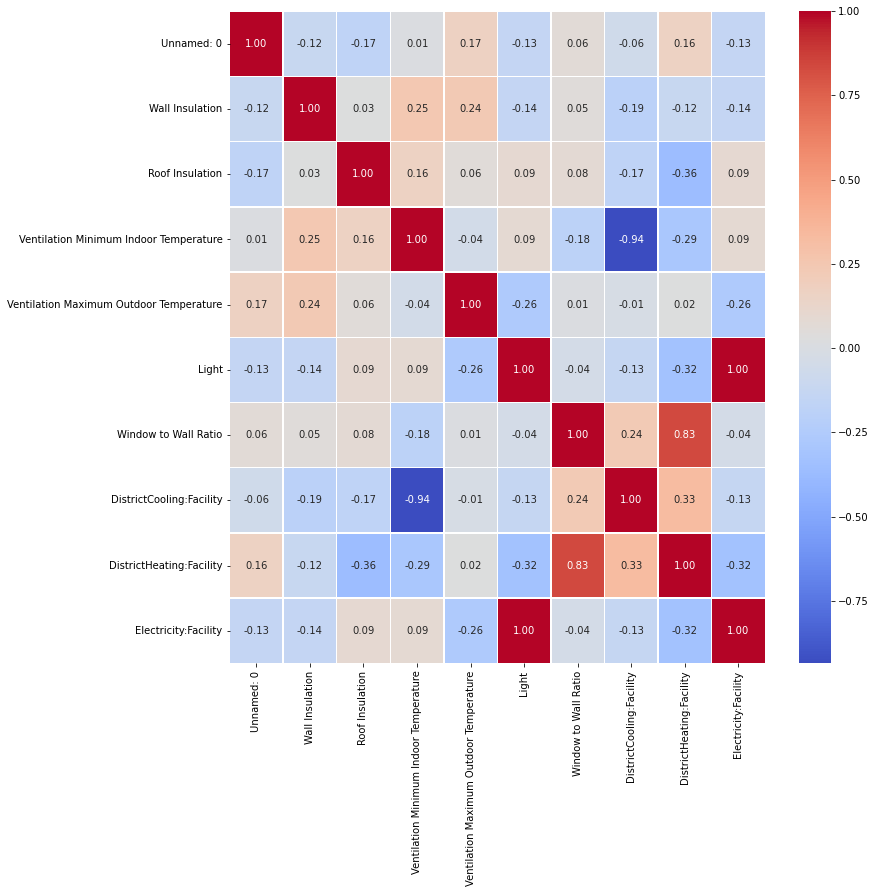

In [49]:
plt.figure(figsize=(12, 12))
sns.heatmap(whole_output.corr(), annot=True, fmt=".2f", linewidth=.5, cmap='coolwarm')
plt.show()

In [37]:
from sklearn import linear_model, pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [24]:
train = whole_output

In [25]:
train.drop("Unnamed: 0", inplace=True, axis=1)

In [27]:
objectives = ["DistrictCooling:Facility", "DistrictHeating:Facility", "Electricity:Facility"]

In [28]:
features = train.loc[:, ~train.columns.isin(objectives)]

In [31]:
features.head()

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
0         0.226995         0.431788                               24.736454   
1         0.122790         0.305375                               22.899821   
2         0.452143         0.197643                               24.994845   
3         0.247014         0.138620                               25.698756   
4         0.320690         0.444994                               20.523009   

   Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  
0                                26.957637  4.748872              0.552881  
1                                26.806571  4.981629              0.537361  
2                                28.000825  3.988760              0.481316  
3                                27.975018  2.622472              0.353992  
4                                28.780984  2.441640              0.575733

In [133]:
# model = pipeline.make_pipeline(StandardScaler(), linear_model.LinearRegression())
# model.fit(features, labels)

In [134]:
# model.predict(np.array([0.42443275767643995, 0.49249707747021, 20.20557160196093, 27.64231775464297, 4.7080108359095405, 0.5849552489165881]).reshape(1, -1))

In [135]:
# row = pd.DataFrame()

In [33]:
features.head()

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
0         0.226995         0.431788                               24.736454   
1         0.122790         0.305375                               22.899821   
2         0.452143         0.197643                               24.994845   
3         0.247014         0.138620                               25.698756   
4         0.320690         0.444994                               20.523009   

   Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  
0                                26.957637  4.748872              0.552881  
1                                26.806571  4.981629              0.537361  
2                                28.000825  3.988760              0.481316  
3                                27.975018  2.622472              0.353992  
4                                28.780984  2.441640              0.575733

In [34]:
labels = train[objectives]
labels.head()

DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility
0              1.010306e+10              6.730259e+10          1.181475e+11
1              1.539228e+10              7.079892e+10          1.195332e+11
2              9.766512e+09              6.982097e+10          1.136223e+11
3              9.316033e+09              7.465076e+10          1.054884e+11
4              3.351746e+10              7.244034e+10          1.044118e+11

In [38]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=100)

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn import 


gp_model = GaussianProcessRegressor().fit(X_train, y_train)

In [41]:
y_pred = gp_model.predict(X_test)

In [42]:
metrics.r2_score(y_test, y_pred)

-9.63446006964176

In [47]:
# metrics.score(y_test, y_pred)

In [48]:
train.head()

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
0         0.226995         0.431788                               24.736454   
1         0.122790         0.305375                               22.899821   
2         0.452143         0.197643                               24.994845   
3         0.247014         0.138620                               25.698756   
4         0.320690         0.444994                               20.523009   

   Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  \
0                                26.957637  4.748872              0.552881   
1                                26.806571  4.981629              0.537361   
2                                28.000825  3.988760              0.481316   
3                                27.975018  2.622472              0.353992   
4                                28.780984  2.441640              0.575733   

   DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  
0              1.010306e+10              6.730259e+10          1.181475e+11  
1              1.539228e+10              7.079892e+10          1.195332e+11  
2              9.766512e+09              6.982097e+10          1.136223e+11  
3              9.316033e+09              7.465076e+10          1.054884e+11  
4              3.351746e+10              7.244034e+10          1.044118e+11

In [49]:
display(features.head(), train[objectives].head())

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
0         0.226995         0.431788                               24.736454   
1         0.122790         0.305375                               22.899821   
2         0.452143         0.197643                               24.994845   
3         0.247014         0.138620                               25.698756   
4         0.320690         0.444994                               20.523009   

   Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  
0                                26.957637  4.748872              0.552881  
1                                26.806571  4.981629              0.537361  
2                                28.000825  3.988760              0.481316  
3                                27.975018  2.622472              0.353992  
4                                28.780984  2.441640              0.575733

DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility
0              1.010306e+10              6.730259e+10          1.181475e+11
1              1.539228e+10              7.079892e+10          1.195332e+11
2              9.766512e+09              6.982097e+10          1.136223e+11
3              9.316033e+09              7.465076e+10          1.054884e+11
4              3.351746e+10              7.244034e+10          1.044118e+11

In [50]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

Couldn't import dot_parser, loading of dot files will not be possible.


In [51]:
X = features
y = labels

In [52]:
# Normalize the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_normalized = scaler_X.fit_transform(X)
y_normalized = scaler_y.fit_transform(y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=100)

In [53]:
# =============================
# Random Forest Regressor Model
# =============================
rfr_model = RandomForestRegressor(random_state=42)
rfr_model.fit(X_train, y_train)

# Evaluate Random Forest
rfr_predictions = rfr_model.predict(X_test)
rfr_rmse = mean_squared_error(y_test, rfr_predictions, squared=False)
rfr_r2 = r2_score(y_test, rfr_predictions)

# Cross-validation
rfr_cv_scores = cross_val_score(rfr_model, X_train, y_train, cv=5, scoring='r2')

In [149]:
# =============================
# Neural Network Model
# =============================
nn_model = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='linear')
])

nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
nn_model.fit(X_train, y_train, epochs=50, batch_size=4, verbose=0, validation_split=0.2)

# Evaluate Neural Network
nn_predictions = nn_model.predict(X_test)
nn_rmse = mean_squared_error(y_test, nn_predictions, squared=False)
nn_r2 = r2_score(y_test, nn_predictions)

In [150]:
# =============================
# Compare Models
# =============================
print("Random Forest Results:")
print(f"RMSE: {rfr_rmse:.4f}, R^2: {rfr_r2:.4f}, CV Mean R^2: {np.mean(rfr_cv_scores):.4f}")

print("\nNeural Network Results:")
print(f"RMSE: {nn_rmse:.4f}, R^2: {nn_r2:.4f}")

Random Forest Results:
RMSE: 0.1366, R^2: 0.7517, CV Mean R^2: 0.6257

Neural Network Results:
RMSE: 0.0598, R^2: 0.9510


In [152]:
from sklearn.model_selection import KFold
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define a function to build the neural network model
def build_model(optimizer='adam', learning_rate=0.001, num_neurons=64, num_layers=2, dropout_rate=0.0):
    model = Sequential()
    model.add(Dense(num_neurons, activation='relu', input_dim=X_train.shape[1]))
    for _ in range(num_layers - 1):
        model.add(Dense(num_neurons, activation='relu'))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    model.add(Dense(y_train.shape[1], activation='linear'))
    optimizer_instance = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer_instance, loss='mse', metrics=['mae'])
    return model

# Wrap the model for compatibility with scikit-learn
model = KerasRegressor(build_fn=build_model, verbose=0)

# Define the hyperparameter grid
param_grid = {
    'optimizer': ['adam'],
    'learning_rate': [0.001, 0.01],
    'num_neurons': [32, 64, 128],
    'num_layers': [2, 3],
    'dropout_rate': [0.0, 0.2],
    'batch_size': [4, 8],
    'epochs': [50, 100]
}

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='r2')
grid_result = grid.fit(X_train, y_train)

# Display the best parameters and corresponding score
print("Best parameters found: ", grid_result.best_params_)
print("Best R^2 score: ", grid_result.best_score_)

# Train final model with best parameters
best_params = grid_result.best_params_
final_model = build_model(
    optimizer=best_params['optimizer'],
    learning_rate=best_params['learning_rate'],
    num_neurons=best_params['num_neurons'],
    num_layers=best_params['num_layers'],
    dropout_rate=best_params['dropout_rate']
)
final_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)

# Evaluate the final model
final_predictions = final_model.predict(X_test)
final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
final_r2 = r2_score(y_test, final_predictions)
print(f"Final RMSE: {final_rmse:.4f}, Final R^2: {final_r2:.4f}")

C:\Users\Saeed\AppData\Local\Temp\ipykernel_19212\1152242758.py:22: DeprecationWarning:

KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.



Best parameters found:  {'batch_size': 8, 'dropout_rate': 0.0, 'epochs': 50, 'learning_rate': 0.01, 'num_layers': 2, 'num_neurons': 128, 'optimizer': 'adam'}
Best R^2 score:  0.921460305534172
Epoch 1/50
4/4 [==============================] - 0s 8ms/step - loss: 0.1357 - mae: 0.3009
Epoch 2/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0475 - mae: 0.1691
Epoch 3/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0275 - mae: 0.1170
Epoch 4/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0137 - mae: 0.0921
Epoch 5/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0110 - mae: 0.0769
Epoch 6/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0099 - mae: 0.0740
Epoch 7/50
4/4 [==============================] - 0s 3ms/step - loss: 0.0073 - mae: 0.0630
Epoch 8/50
4/4 [==============================] - 0s 3ms/step - loss: 0.0056 - mae: 0.0555
Epoch 9/50
4/4 [==============================] - 0s 3ms/step - loss: 0.0047 - 

In [54]:
!pip install pymoo


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Epoch 1/50
4/4 [==============================] - 1s 7ms/step - loss: 0.1114 - mae: 0.2701
Epoch 2/50
4/4 [==============================] - 0s 3ms/step - loss: 0.0350 - mae: 0.1418
Epoch 3/50
4/4 [==============================] - 0s 3ms/step - loss: 0.0242 - mae: 0.1271
Epoch 4/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0174 - mae: 0.0991
Epoch 5/50
4/4 [==============================] - 0s 2ms/step - loss: 0.0112 - mae: 0.0774
Epoch 6/50
4/4 [==============================] - 0s 3ms/step - loss: 0.0064 - mae: 0.0612
Epoch 7/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0077 - mae: 0.0632
Epoch 8/50
4/4 [==============================] - 0s 0s/step - loss: 0.0034 - mae: 0.0464
Epoch 9/50
4/4 [==============================] - 0s 0s/step - loss: 0.0027 - mae: 0.0411
Epoch 10/50
4/4 [==============================] - 0s 0s/step - loss: 0.0026 - mae: 0.0384
Epoch 11/50
4/4 [==============================] - 0s 0s/step - loss: 0.0013 - mae: 0.0297
E

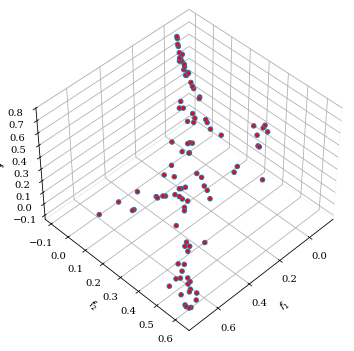

In [64]:
import numpy as np
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pymoo.visualization.scatter import Scatter

# Define the surrogate model with the best parameters
def build_final_model():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(y_train.shape[1], activation='linear'))
    optimizer_instance = Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer_instance, loss='mse', metrics=['mae'])
    return model

# Train the surrogate model
final_model = build_final_model()
final_model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=1)

# Define the optimization problem
class BuildingOptimizationProblem(Problem):
    def __init__(self):
        super().__init__(
            n_var=X_train.shape[1],  # Number of input parameters
            n_obj=3,  # Number of objectives
            n_constr=0,  # No constraints
            xl=0,  # Lower bounds for parameters
            xu=1,  # Upper bounds for parameters (normalized input space)
        )

    def _evaluate(self, X, out, *args, **kwargs):
        # Predict objectives using the trained model
        predictions = final_model.predict(X)
        out["F"] = predictions  # Objective values for minimization

# Instantiate the problem
problem = BuildingOptimizationProblem()

# Set up the optimization algorithm (NSGA-II)
algorithm = NSGA2(pop_size=100)

# Run the optimization
res = minimize(
    problem,
    algorithm,
    termination=('n_gen', 200),  # Run for 200 generations
    seed=1,
    save_history=True,
    verbose=True,
)

# Visualize the Pareto front
scatter = Scatter()
scatter.add(res.F, facecolor="red")
scatter.show()

# Extract the Pareto-optimal solutions
pareto_solutions = res.X
pareto_objectives = res.F

# Display results
print("Pareto-optimal solutions (parameters):")
print(pareto_solutions)
print("Pareto-optimal objectives (cooling, heating, electricity):")
print(pareto_objectives)

In [57]:
import numpy as np
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pymoo.visualization.scatter import Scatter
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Define the surrogate model with the best parameters
def build_final_model():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(y_train.shape[1], activation='linear'))
    optimizer_instance = Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer_instance, loss='mse', metrics=['mae'])
    return model

# Train the surrogate model
final_model = build_final_model()
final_model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=1)

# Define the optimization problem
class BuildingOptimizationProblem(Problem):
    def __init__(self):
        super().__init__(
            n_var=X_train.shape[1],  # Number of input parameters
            n_obj=3,  # Number of objectives
            n_constr=0,  # No constraints
            xl=0,  # Lower bounds for parameters
            xu=1,  # Upper bounds for parameters (normalized input space)
        )

    def _evaluate(self, X, out, *args, **kwargs):
        # Predict objectives using the trained model
        predictions = final_model.predict(X)
        out["F"] = predictions  # Objective values for minimization

# Instantiate the problem
problem = BuildingOptimizationProblem()

# Set up the optimization algorithm (NSGA-II)
algorithm = NSGA2(pop_size=200)  # Increased population size

# Run the optimization with more generations
res = minimize(
    problem,
    algorithm,
    termination=('n_gen', 1000),  # Increased generations
    seed=1,
    save_history=True,
    verbose=True,
)

Epoch 1/50
4/4 [==============================] - 0s 7ms/step - loss: 0.1298 - mae: 0.2927
Epoch 2/50
4/4 [==============================] - 0s 3ms/step - loss: 0.0413 - mae: 0.1648
Epoch 3/50
4/4 [==============================] - 0s 7ms/step - loss: 0.0259 - mae: 0.1195
Epoch 4/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0164 - mae: 0.0949
Epoch 5/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0139 - mae: 0.0904
Epoch 6/50
4/4 [==============================] - 0s 1ms/step - loss: 0.0084 - mae: 0.0728
Epoch 7/50
4/4 [==============================] - 0s 3ms/step - loss: 0.0047 - mae: 0.0522
Epoch 8/50
4/4 [==============================] - 0s 5ms/step - loss: 0.0057 - mae: 0.0600
Epoch 9/50
4/4 [==============================] - 0s 3ms/step - loss: 0.0051 - mae: 0.0573
Epoch 10/50
4/4 [==============================] - 0s 2ms/step - loss: 0.0027 - mae: 0.0425
Epoch 11/50
4/4 [==============================] - 0s 3ms/step - loss: 0.0030 - mae: 0.04

In [67]:
# Use final population only (the actual last generation)
all_F = res.pop.get("F")

nds = NonDominatedSorting()
front_idx = nds.do(all_F, only_non_dominated_front=True)
pareto_front = all_F[front_idx]

print("Total points in final population:", all_F.shape[0])
print("Pareto front points in final population:", pareto_front.shape[0])


Total points in final population: 100
Pareto front points in final population: 100


In [70]:
print("Objectives min:", np.min(all_F, axis=0))
print("Objectives max:", np.max(all_F, axis=0))


Objectives min: [-0.10177712 -0.08376072 -0.07697713]
Objectives max: [0.72056496 0.62226468 0.74217355]


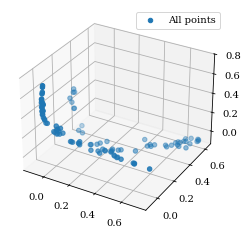

In [69]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(all_F[:, 0], all_F[:, 1], all_F[:, 2], label='All points')
plt.legend()
plt.show()


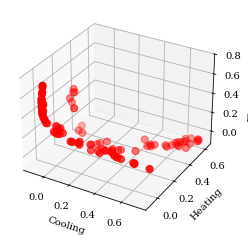

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# Get Pareto-optimal objective values
pareto_objectives = res.F

# Plot in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    pareto_objectives[:, 0],  # Cooling
    pareto_objectives[:, 1],  # Heating
    pareto_objectives[:, 2],  # Electricity
    color='red',
    s=50
)
ax.set_xlabel("Cooling")
ax.set_ylabel("Heating")
ax.set_zlabel("Electricity")
plt.show()


Final population size: 100
Pareto front size: 100


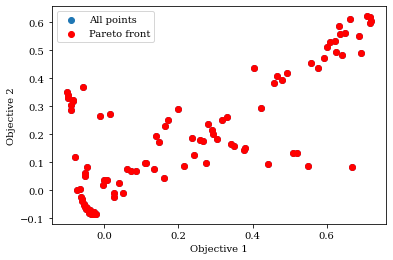

In [66]:
import matplotlib.pyplot as plt
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

# Use final population only
all_F = res.pop.get("F")

nds = NonDominatedSorting()
front_idx = nds.do(all_F, only_non_dominated_front=True)
pareto_front = all_F[front_idx]

print("Final population size:", all_F.shape[0])
print("Pareto front size:", pareto_front.shape[0])

plt.scatter(all_F[:, 0], all_F[:, 1], label="All points")
plt.scatter(pareto_front[:, 0], pareto_front[:, 1], color="red", label="Pareto front")
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.legend()
plt.show()


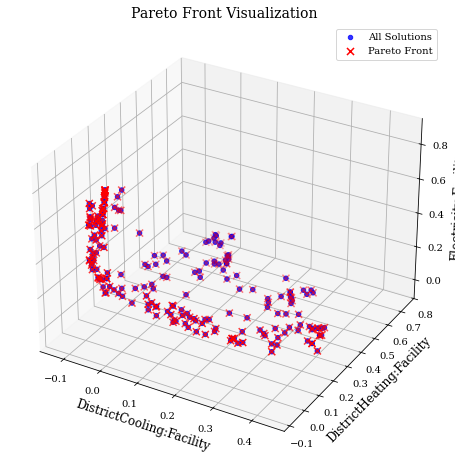

Pareto-optimal solutions (parameters):
[[4.95954830e-01 9.39743511e-01 2.89775614e-01 1.29148448e-03
  2.62185490e-04 1.37898903e-01]
 [9.99999891e-01 9.99999243e-01 9.99999993e-01 1.58856932e-01
  9.99985985e-01 3.57057501e-08]
 [9.99999879e-01 9.99999722e-01 9.99999993e-01 1.61776452e-01
  9.99997184e-01 2.30962013e-07]
 ...
 [9.08297280e-01 9.99215740e-01 9.80334782e-01 5.07317106e-02
  1.25230766e-03 3.26118945e-01]
 [9.92094808e-01 9.92647368e-01 3.84422510e-01 5.16532891e-02
  7.48276553e-02 3.87441475e-03]
 [9.95641959e-01 9.99867622e-01 4.59174507e-01 1.80309824e-01
  1.82978404e-04 7.55731122e-03]]
Pareto-optimal objectives (cooling, heating, electricity):
[[ 4.40997064e-01  1.95594236e-01  3.92853320e-02]
 [ 1.50865689e-03 -7.55602270e-02  8.78441691e-01]
 [ 1.50986761e-03 -7.55650401e-02  8.78431261e-01]
 [-1.24410272e-01  3.02425027e-01  5.30905485e-01]
 [ 2.83014983e-01  5.93378425e-01 -4.53833081e-02]
 [-6.85088336e-04  7.43352532e-01  2.95381621e-03]
 [ 4.10122007e-01  2

In [63]:
# Extract the Pareto-optimal solutions
pareto_solutions = res.X
pareto_objectives = res.F

# Visualize the Pareto front in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot all results in the background
ax.scatter(
    res.F[:, 0], res.F[:, 1], res.F[:, 2],
    c='blue', label='All Solutions', alpha=0.8
)

# Plot Pareto-optimal front
ax.scatter(
    pareto_objectives[:, 0], pareto_objectives[:, 1], pareto_objectives[:, 2],
    c='red', label='Pareto Front', s=50, marker='x'
)

# Label axes with objective names
ax.set_xlabel('DistrictCooling:Facility', fontsize=12)
ax.set_ylabel('DistrictHeating:Facility', fontsize=12)
ax.set_zlabel('Electricity:Facility', fontsize=12)
ax.set_title('Pareto Front Visualization', fontsize=14)
ax.legend()
plt.show()

# Display Pareto solutions and objectives
print("Pareto-optimal solutions (parameters):")
print(pareto_solutions)
print("Pareto-optimal objectives (cooling, heating, electricity):")
print(pareto_objectives)

In [180]:
print(list(pareto_solutions[0]))
print(list(pareto_objectives[0]))

[0.04509236719215151, 0.9999999889684704, 0.42205969367692203, 0.9999997539776916, 2.386966548440826e-09, 0.37082248268616536]
[0.338029146194458, 0.3698044419288635, -0.04213681071996689]


### paretor solutions

In [7]:
import numpy as np

results = '''[[ 3.38029146e-01  3.69804442e-01 -4.21368107e-02]
 [ 5.59356630e-01  1.12365291e-01  1.38749927e-03]
 [-1.41449958e-01  3.42492789e-01 -2.34469660e-02]
 [-1.31027669e-01  4.60009694e-01 -3.72166261e-02]
 [ 1.36294633e-01 -1.17112279e-01  9.16589200e-01]
 [ 9.71040428e-02 -1.09240204e-01  8.48905623e-01]
 [ 2.75554955e-01  3.90639663e-01 -3.91690433e-02]
 [ 3.20085920e-02 -8.96810889e-02  6.80994987e-01]
 [ 6.27076626e-03 -7.12971836e-02  5.54464638e-01]
 [ 8.41232389e-02 -9.86928493e-02  7.59131312e-01]
 [ 4.04653013e-01  2.06517830e-01 -1.70395002e-02]
 [ 6.92549497e-02 -1.02026463e-01  8.03578913e-01]
 [ 4.18087453e-01  2.62458831e-01 -2.66442113e-02]
 [-3.17886695e-02  2.60119289e-02  2.10179597e-01]
 [ 2.38478810e-01  2.95162886e-01 -3.05962488e-02]
 [-8.69550034e-02  1.04613557e-01  9.15675908e-02]
 [ 7.52247870e-02 -9.39950347e-02  7.24695325e-01]
 [ 3.15418750e-01  2.55606920e-01 -2.56647058e-02]
 [ 4.73676585e-02 -9.52659696e-02  7.39431143e-01]
 [ 1.30774647e-01 -1.12757787e-01  8.74301910e-01]
 [ 2.25283980e-01  7.56465271e-02  2.86268555e-02]
 [ 1.12178959e-01 -1.04703978e-01  7.92219222e-01]
 [ 3.26760374e-02 -8.05256814e-02  6.09351397e-01]
 [ 3.63813907e-01  1.95407137e-01 -1.45883709e-02]
 [ 4.65296060e-01  1.49141356e-01 -1.01262704e-03]
 [ 7.64748529e-02 -1.10975400e-01  8.92182708e-01]
 [-1.00976154e-02 -6.08651750e-02  5.01386106e-01]
 [ 3.33182454e-01  3.52914929e-01 -3.98963168e-02]
 [-9.73333791e-02  1.17189512e-01  6.87323883e-02]
 [ 6.27068654e-02 -1.05894148e-01  8.37950289e-01]
 [ 1.20914608e-01 -1.07008055e-01  8.30347121e-01]
 [ 5.50357580e-01  1.27592355e-01  1.55849755e-03]
 [ 2.59681076e-01  2.28542954e-01 -1.38402991e-02]
 [-1.08412430e-02 -6.19562306e-02  5.14762640e-01]
 [-3.76059785e-02  5.51657043e-02  1.33760929e-01]
 [ 2.86978446e-02 -8.77874792e-02  6.60594225e-01]
 [ 2.50921771e-02 -8.54988992e-02  6.43701494e-01]
 [ 4.29622307e-02 -9.09178704e-02  6.94036365e-01]
 [ 5.00396080e-02 -9.68425423e-02  7.48401761e-01]
 [ 2.49073356e-01  8.20491612e-02  2.36346051e-02]
 [ 1.05749205e-01 -1.01057455e-01  7.65570223e-01]
 [-6.23136237e-02  3.64770703e-02  4.64940280e-01]
 [-5.04881367e-02  4.72339764e-02  1.88647866e-01]
 [-2.15090662e-02 -4.92712073e-02  4.36173469e-01]
 [ 3.81222188e-01  2.34205648e-01 -2.20970735e-02]
 [-1.25946879e-01  3.05028558e-01 -1.16759874e-02]
 [-9.98677537e-02  3.64742815e-01 -2.44456120e-02]
 [ 4.56948906e-01  1.28137276e-01  1.85278058e-03]
 [-2.58630365e-02 -2.90309004e-02  3.58355850e-01]
 [ 3.42780113e-01  3.23387980e-01 -3.79556268e-02]
 [-5.75599596e-02  6.48796335e-02  1.47352993e-01]
 [ 3.78785729e-01  2.19193414e-01 -2.06478499e-02]
 [-1.28005415e-01  4.46775347e-01 -3.57063338e-02]
 [ 2.85820693e-01  1.67173326e-01 -5.12214750e-03]
 [-7.17364252e-03 -3.62752788e-02  3.87183547e-01]
 [-3.88187692e-02 -2.39927322e-03  4.44599122e-01]
 [-4.23103571e-03 -6.53022677e-02  5.25324523e-01]
 [ 3.96972932e-02 -9.14187580e-02  7.03875661e-01]
 [-6.98292330e-02  6.76618963e-02  2.25688577e-01]
 [-7.26976246e-03 -3.54398154e-02  3.84130567e-01]
 [ 3.09689134e-01  2.86089391e-01 -3.32355499e-02]
 [ 1.24920279e-01 -1.16676211e-01  9.15038109e-01]
 [ 1.17966622e-01 -1.04977489e-01  8.19691956e-01]
 [-4.59232554e-02  1.78531520e-02  2.48035133e-01]
 [-1.24123283e-01  4.14466947e-01 -2.82801464e-02]
 [ 5.86160831e-02 -1.03729472e-01  8.12589765e-01]
 [-1.27426475e-01  4.59148616e-01 -3.69107351e-02]
 [-1.91884860e-02 -2.61604898e-02  3.52977097e-01]
 [ 1.08915776e-01 -1.11916721e-01  8.77272964e-01]
 [ 1.91537797e-01  3.99252057e-01 -3.60144377e-02]
 [ 3.02823931e-01  2.75598824e-01 -2.97892243e-02]
 [ 1.00899644e-01 -1.16043791e-01  9.05342579e-01]
 [ 2.19341785e-01  2.81344056e-01 -2.79786922e-02]
 [ 1.47960186e-01  2.48026952e-01 -2.04329565e-03]
 [-4.49602529e-02  1.45891681e-02  2.56794840e-01]
 [ 5.05024195e-01  1.82649642e-01 -9.84490290e-03]
 [ 3.98992747e-01  3.21109235e-01 -3.61039713e-02]
 [ 5.16750216e-01  1.03434436e-01  2.95356661e-03]
 [ 1.87651515e-01  3.50434810e-01 -3.35369706e-02]
 [ 2.00737789e-01  3.34114701e-01 -2.85512209e-02]
 [-1.28831446e-01  4.31351632e-01 -3.36525217e-02]
 [ 5.34172773e-01  1.09706126e-01  1.65008754e-03]
 [ 1.79745823e-01  3.74111533e-01 -3.52451205e-02]
 [ 3.24370831e-01  2.84191728e-01 -3.24492902e-02]
 [ 2.52774537e-01  1.91038176e-01 -6.29669055e-03]
 [-3.01223993e-02 -1.65070482e-02  3.14023674e-01]
 [ 4.30525869e-01  1.02837369e-01  1.15137640e-02]
 [-6.81449100e-02  9.19475257e-02  1.05511859e-01]
 [ 3.89593631e-01  3.11586678e-01 -3.32710370e-02]
 [ 3.67504470e-02 -9.20812190e-02  7.10668564e-01]
 [ 4.40169014e-02 -9.33028609e-02  7.14385390e-01]
 [ 2.10376740e-01  2.11164013e-01 -1.10896565e-02]
 [-3.32425758e-02 -2.11464576e-02  3.43875498e-01]
 [-7.99232051e-02  1.19054735e-01  5.47855198e-02]
 [ 2.75619514e-02 -8.67678076e-02  6.59914374e-01]
 [-2.80095115e-02 -1.54622011e-02  3.06039572e-01]
 [ 1.46312639e-02 -7.88662881e-02  5.96636951e-01]
 [ 1.10056698e-02 -7.64867663e-02  5.94617546e-01]
 [ 1.39160618e-01  3.17412138e-01 -1.33377165e-02]
 [ 2.33880728e-01  3.15378159e-01 -3.42447460e-02]
 [ 3.21146101e-03 -6.96016997e-02  5.45868397e-01]
 [ 4.96342421e-01  1.84302002e-01 -9.78313759e-03]
 [ 5.19017130e-02 -9.98425335e-02  7.81924069e-01]
 [-2.44517028e-02 -2.04896219e-02  3.22871715e-01]
 [-2.75495052e-02  7.25225359e-03  2.38825202e-01]
 [-4.03120592e-02 -1.11365803e-02  4.54823643e-01]
 [ 2.43515491e-01  9.46513712e-02  1.86780058e-02]
 [-1.17269970e-01  4.08495784e-01 -3.10370699e-02]
 [ 1.71567112e-01  1.74805462e-01  3.45610641e-03]
 [-1.37269258e-01  4.06648993e-01 -2.63812840e-02]
 [ 4.22808945e-01  9.59193408e-02  1.16016176e-02]
 [-2.93802172e-02 -3.14122550e-02  3.72558802e-01]
 [ 3.19206923e-01  2.15313911e-01 -1.67121217e-02]
 [ 2.66459227e-01  2.32035443e-01 -1.44822970e-02]
 [ 1.64793283e-01  4.39122990e-02  1.20102726e-01]
 [-1.15252115e-01  3.80256981e-01 -2.68737897e-02]
 [ 2.97419727e-04 -6.78558648e-02  5.74702144e-01]
 [ 2.13118672e-01  2.45441228e-01 -1.93397589e-02]
 [ 2.68710822e-01  2.42824420e-01 -1.87799297e-02]
 [ 1.44011527e-03 -6.95689023e-02  5.78903198e-01]
 [-1.34890169e-01  4.35301423e-01 -2.88599133e-02]
 [ 1.54589906e-01  3.31974596e-01 -2.67322510e-02]
 [-1.04808129e-01  1.32369146e-01  4.82097641e-02]
 [ 2.69956067e-02 -7.66642839e-02  5.89491785e-01]
 [-2.12607384e-02 -2.43960433e-02  3.39261413e-01]
 [ 8.14960226e-02 -1.15653872e-01  9.03176785e-01]
 [-3.82302776e-02  8.00870359e-04  3.98907363e-01]
 [ 4.47748572e-01  1.55209541e-01 -4.78987023e-03]
 [-1.36574060e-02 -5.59159480e-02  4.89549428e-01]
 [-2.56166756e-02 -5.00535592e-03  2.73187578e-01]
 [ 1.09387912e-01 -1.14464045e-01  8.98278534e-01]
 [ 1.97506309e-01  3.37612718e-01 -2.86826193e-02]
 [ 4.73887205e-01  1.63493335e-01 -5.19005954e-03]
 [-3.72131839e-02  5.01029156e-02  1.42502815e-01]
 [-1.34641677e-01  4.22338545e-01 -2.78317071e-02]
 [-1.49329528e-02  4.46161777e-02  1.57121345e-01]
 [ 1.50408298e-02 -7.99573958e-02  6.22236490e-01]
 [-2.81349123e-02  2.91565191e-02  2.04004884e-01]
 [-1.06374659e-01  1.37414590e-01  4.39283922e-02]
 [-1.13463603e-01  4.42387462e-01 -3.50843295e-02]
 [-1.08803831e-01  1.40607610e-01  4.24102284e-02]
 [ 5.46892658e-02 -9.91214514e-02  7.75671124e-01]
 [ 3.59018058e-01  2.02048227e-01 -1.18852444e-02]
 [ 2.29678035e-01  2.89382845e-01 -2.98767313e-02]
 [ 3.94603938e-01  1.21169403e-01  4.35320474e-03]
 [-4.98666093e-02  1.21692009e-02  4.74118799e-01]
 [ 2.45797187e-01  6.04646690e-02  9.77804288e-02]
 [-1.55765936e-02 -5.42915650e-02  4.79920715e-01]
 [ 2.94602066e-01  2.69481003e-01 -2.61592269e-02]
 [-5.55434600e-02  3.85762528e-02  2.67058402e-01]
 [ 2.03916058e-02 -8.35199058e-02  6.21846557e-01]
 [-2.59440020e-02 -1.90648027e-02  3.31339478e-01]
 [-2.01591626e-02 -5.22154756e-02  4.52179700e-01]
 [ 4.91042227e-01  1.77111670e-01 -8.91147926e-03]
 [ 3.54589641e-01  1.25350043e-01  4.45468724e-03]
 [ 4.84798610e-01  1.71854749e-01 -8.03105161e-03]
 [-9.19225141e-02  8.80630240e-02  2.05112606e-01]
 [ 1.11714602e-02 -7.72438198e-02  6.18998587e-01]
 [ 1.71143562e-01  3.47802192e-01 -3.23021337e-02]
 [-1.35851115e-01  4.22543645e-01 -2.78666355e-02]
 [ 1.57597512e-01  2.24159360e-01 -1.07152686e-02]
 [ 5.20541966e-01  2.40777850e-01 -2.23403126e-02]
 [-1.29589558e-01  3.24529260e-01 -1.17541105e-02]
 [-1.61562338e-02  5.83494380e-02  1.25360042e-01]
 [ 3.70545924e-01  8.80357251e-02  1.36283729e-02]
 [-1.23241581e-01  4.44112629e-01 -3.53705138e-02]
 [ 1.68524578e-01  1.51859760e-01  1.02325473e-02]
 [-2.82487795e-02 -1.03706755e-02  2.99367905e-01]
 [ 1.44517392e-01  2.83709019e-01 -2.36020535e-02]
 [-1.10541843e-01  3.98903936e-01 -2.88003832e-02]
 [-2.93838978e-02 -3.13611887e-02  3.72583032e-01]
 [ 2.98193336e-01  1.88702881e-01 -5.30150905e-03]
 [ 4.93843168e-01  1.81384057e-01 -9.68217850e-03]
 [ 1.53780937e-01  9.08193812e-02  3.57967615e-02]
 [-2.91555449e-02  2.80426815e-03  2.47431874e-01]
 [-9.47129205e-02  1.30367875e-01  4.51085344e-02]
 [-5.13391867e-02  1.47828050e-02  4.77334470e-01]
 [-8.54463503e-02  1.18607894e-01  5.94114587e-02]
 [ 3.73740882e-01  2.67049521e-01 -2.61650793e-02]
 [ 2.22725004e-01  1.58231556e-01  4.48385812e-03]
 [-2.25422084e-02 -4.69629876e-02  4.24682111e-01]
 [-1.11074783e-01  3.83986235e-01 -2.78481059e-02]
 [ 3.33545953e-01  3.69751900e-01 -4.20148373e-02]
 [-1.74490958e-02 -5.23165129e-02  4.69038993e-01]
 [ 2.43978053e-02 -8.36082101e-02  6.30798221e-01]
 [ 5.25300026e-01  1.08858958e-01  1.81267783e-03]
 [-3.51337269e-02  3.81166115e-02  1.64891422e-01]
 [ 2.99952447e-01  2.73332894e-01 -2.85277665e-02]
 [ 5.02867520e-01  1.07810199e-01  3.19601595e-03]
 [ 4.33403194e-01  9.50485319e-02  8.30863416e-03]
 [ 1.79854274e-01  8.29104781e-02  4.49532643e-02]
 [ 2.33826265e-02 -8.46748054e-02  6.35221124e-01]
 [-7.59679005e-02  9.86692160e-02  9.84141752e-02]
 [-2.81599909e-02 -8.23695585e-03  2.93224365e-01]
 [-1.09403081e-01  1.60916924e-01  3.49268764e-02]
 [-1.27938613e-02 -5.50409369e-02  4.89537269e-01]
 [-4.87097129e-02  1.37428194e-03  3.33846241e-01]
 [-2.58814618e-02  4.74065542e-04  2.54233569e-01]
 [ 4.82028782e-01  1.66475996e-01 -6.47869706e-03]
 [-2.38817036e-02 -4.46367301e-02  4.15828317e-01]]'''


In [11]:
arr = np.array([list(map(float, line.split())) 
                for line in results.replace('[', '').replace(']', '').split('\n') if line.strip()])

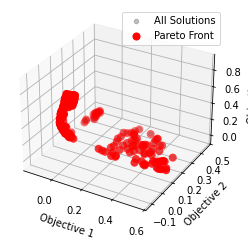

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def pareto_front(points, maximize=False):
    points = np.array(points)
    is_pareto = np.ones(points.shape[0], dtype=bool)

    for i, p in enumerate(points):
        if maximize:
            # A point is dominated if another is >= in all objectives and > in at least one
            dominated = np.all(points >= p, axis=1) & np.any(points > p, axis=1)
        else:
            # A point is dominated if another is <= in all objectives and < in at least one
            dominated = np.all(points <= p, axis=1) & np.any(points < p, axis=1)

        if np.any(dominated):
            is_pareto[i] = False

    return points[is_pareto]

# Get Pareto front points
pareto_points = pareto_front(arr, maximize=False)  # or True if you maximize objectives

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter all points
ax.scatter(arr[:,0], arr[:,1], arr[:,2], color='gray', alpha=0.5, label='All Solutions')

# Highlight Pareto front points
ax.scatter(pareto_points[:,0], pareto_points[:,1], pareto_points[:,2], 
           color='red', s=50, label='Pareto Front')

ax.set_xlabel('Objective 1')
ax.set_ylabel('Objective 2')
ax.set_zlabel('Objective 3')
ax.legend()
plt.show()


In [172]:
list(besos_problem)

[Parameter(selector=FieldSelector(field_name='Thickness', class_name='Material', object_name='_InsulationEX_.01'), value_descriptors=[RangeParameter(min=0.1, max=0.5)]),
 Parameter(selector=FieldSelector(field_name='Thickness', class_name='Material', object_name='_InsulationEX_Roof_.01'), value_descriptors=[RangeParameter(min=0.1, max=0.5)]),
 Parameter(selector=FieldSelector(field_name='Minimum Indoor Temperature', class_name='ZoneVentilation:DesignFlowRate', object_name='*'), value_descriptors=[RangeParameter(min=20, max=26)]),
 Parameter(selector=FieldSelector(field_name='Maximum Outdoor Temperature', class_name='ZoneVentilation:DesignFlowRate', object_name='*'), value_descriptors=[RangeParameter(min=26, max=30)]),
 Parameter(selector=FieldSelector(field_name='Watts per Zone Floor Area', class_name='Lights', object_name='*'), value_descriptors=[RangeParameter(min=2, max=5)]),
 Parameter(selector=wwrSelector(), value_descriptors=[RangeParameter(min=0.1, max=0.9)]),
 MeterReader(class

In [229]:
# Pick the first Pareto solution
solution_index = 1
selected_solution = pareto_solutions[solution_index]
selected_objectives = pareto_objectives[solution_index]

# Denormalize the solution
denormalized_solution = scaler_X.inverse_transform([selected_solution])[0]
denormalized_objectives = scaler_y.inverse_transform([selected_objectives])[0]

# Prepare outputs
denormalized_params = pd.DataFrame(
    [denormalized_solution],
    columns=param_columns
)
objective_columns = [
    "DistrictCooling:Facility",
    "DistrictHeating:Facility",
    "Electricity:Facility"
]
denormalized_objectives = pd.DataFrame(
    [denormalized_objectives],
    columns=objective_columns
)

In [230]:
denormalized_params

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
0         0.226049         0.499278                               21.019485   

   Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  
0                                29.902309  2.073593              0.122836

In [231]:
denormalized_objectives

DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility
0              2.616975e+10              6.111491e+10          1.022448e+11

In [244]:
denormalized_params.iloc[0].to_dict()

{'Wall Insulation': 0.2260488677296411,
 'Roof Insulation': 0.49927808266980855,
 'Ventilation Minimum Indoor Temperature': 21.019484529382925,
 'Ventilation Maximum Outdoor Temperature': 29.90230866910201,
 'Light': 2.073593178852667,
 'Window to Wall Ratio': 0.12283621776002285}

In [252]:
# from eppy import modeleditor
# from eppy.modeleditor import IDF


# # Initialize the IDF
# idf_file = idf_path
# IDF.setiddname("C://EnergyPlusV9-6-0/Energy+.idd")  # Ensure to point to the correct .idd file
# idf = IDF(idf_file, epw_path)

# # # Optimal parameters (replace these with the final optimized values)
# # optimal_values = {
# #     "_InsulationEX_.01": 0.226049,
# #     "_InsulationEX_Roof_.01": 0.499278,
# #     "Minimum Indoor Temperature": 21.019485,
# #     "Maximum Outdoor Temperature": 29.902309,
# #     "Watts per Zone Floor Area": 2.073593,
# #     "Window to Wall Ratio": 0.122836
# # }

# # Optimal parameter values
# optimal_values = {
#     "_InsulationEX_.01": ("Material", "Thickness", 0.226049),
#     "_InsulationEX_Roof_.01": ("Material", "Thickness", 0.499278),
#     # "*": ("ZoneVentilation:DesignFlowRate", "Minimum Indoor Temperature", 23.985767),
#     # "*_MaxOutdoorTemp": ("ZoneVentilation:DesignFlowRate", "Maximum Outdoor Temperature", 26.714961),
#     # "*_Light": ("Lights", "Watts per Zone Floor Area", 4.547935),
#     # "WWR": ("WindowMaterial:Glazing", "Solar Transmittance at Normal Incidence", 0.553791)  # Example for WWR
# }

# # Update IDF file based on optimal values
# for obj_name, (class_name, field_name, value) in optimal_values.items():
#     for obj in idf.idfobjects[class_name.upper()]:
#         # Handle cases with specific names
#         if obj_name == "*" or (hasattr(obj, "Name") and obj.Name == obj_name):
#             if hasattr(obj, field_name):
#                 setattr(obj, field_name, value)


# # Save the updated IDF file
# updated_idf_file = "test_updated_building.idf"
# idf.saveas(updated_idf_file)

# print(f"Updated IDF file saved to {updated_idf_file}")

In [251]:
# Optimal parameter values
optimal_values = {
    "_InsulationEX_.01": ("Material", "Thickness", 0.226049),
    "_InsulationEX_Roof_.01": ("Material", "Thickness",  0.499278),
    "*": ("ZoneVentilation:DesignFlowRate", "Minimum Indoor Temperature", 21.019485),
    "*_MaxOutdoorTemp": ("ZoneVentilation:DesignFlowRate", "Maximum Outdoor Temperature", 29.902309),
    "*_Light": ("Lights", "Watts per Zone Floor Area", 2.073593),
    "WWR": ("WindowMaterial:Glazing", "Solar Transmittance at Normal Incidence", 0.122836)  # Example for WWR
}

# Update IDF file based on optimal values
for obj_name, (class_name, field_name, value) in optimal_values.items():
    for obj in idf.idfobjects[class_name.upper()]:
        # Handle cases with specific names
        if obj_name == "*" or (hasattr(obj, "Name") and obj.Name == obj_name):
            if hasattr(obj, field_name):
                setattr(obj, field_name, value)

# Update Ventilation Parameters: Minimum Indoor Temperature and Maximum Outdoor Temperature
for obj in idf.idfobjects["ZoneVentilation:DesignFlowRate"]:
    if hasattr(obj, "Minimum_Indoor_Temperature"):
        obj.Minimum_Indoor_Temperature = 21.019485  # Update value as per optimal
    if hasattr(obj, "Maximum_Outdoor_Temperature"):
        obj.Maximum_Outdoor_Temperature = 29.902309  # Update value as per optimal

# Update Lights: Watts per Zone Floor Area
for obj in idf.idfobjects["Lights"]:
    if hasattr(obj, "Watts_per_Zone_Floor_Area"):
        obj.Watts_per_Zone_Floor_Area = 2.073593  # Update value as per optimal

# Update Window to Wall Ratio (WWR) - Example for WindowMaterial:Glazing
for obj in idf.idfobjects["WindowMaterial:Glazing"]:
    if hasattr(obj, "Solar_Transmittance_at_Normal_Incidence"):
        obj.Solar_Transmittance_at_Normal_Incidence = 0.122836  # Adjust for WWR, if applicable

# Save the updated IDF file
updated_idf_file = "test2_updated_building.idf"
idf.saveas(updated_idf_file)

print(f"Updated IDF file saved to {updated_idf_file}")

Updated IDF file saved to test2_updated_building.idf


## Genetic Optimization

In [16]:
results = NSGAII(evaluator, evaluations=20, population_size=20)
results

[0.3003006142282619, 0.17449492014309964, 21.80608165648259, 28.673267073583652, 2.9085053512798527, 0.6734379343334777]
[
Material,
    _InsulationEX_.01,        !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.034,                    !- Conductivity
    35,                       !- Density
    1400,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
Material,
    _InsulationEX_Roof_.01,    !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.04,                     !- Conductivity
    12,                       !- Density
    840,                      !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.6,                      !- Solar Absorptance
    0.6;                      !- Visible Absorptance
]
[
ZoneVentilation:De

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
0          0.300301         0.174495                               21.806082   
1          0.328017         0.393929                               22.196292   
2          0.352485         0.397383                               22.143735   
3          0.418072         0.204972                               24.899681   
4          0.401552         0.108979                               24.759609   
5          0.458734         0.347286                               20.274558   
6          0.280110         0.139046                               23.574363   
7          0.251112         0.363833                               22.291314   
8          0.496731         0.187830                               25.315381   
9          0.495228         0.455142                               24.195236   
10         0.291898         0.346142                               22.409125   
11         0.332687         0.206036                               23.057997   
12         0.424433         0.492497                               20.205572   
13         0.201359         0.443517                               21.103065   
14         0.171999         0.265559                               25.275458   
15         0.232033         0.449485                               25.254274   
16         0.308525         0.470700                               22.439543   
17         0.102877         0.434327                               22.544309   
18         0.222231         0.412885                               23.548136   
19         0.198316         0.415904                               23.503202   

    Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  \
0                                 28.673267  2.908505              0.673438   
1                                 29.310447  2.964310              0.125425   
2                                 28.521718  4.466999              0.464416   
3                                 28.722212  4.083250              0.199889   
4                                 29.182299  2.597861              0.616199   
5                                 27.248201  3.025147              0.387707   
6                                 29.115941  2.865000              0.733610   
7                                 27.253983  4.520938              0.327292   
8                                 28.169938  4.789222              0.309144   
9                                 27.671600  4.129499              0.189895   
10                                27.731247  2.842918              0.308053   
11                                26.458076  3.988971              0.254202   
12                                27.642318  4.708011              0.584955   
13                                27.871208  2.362191              0.746469   
14                                29.760957  4.047619              0.544104   
15                                29.250047  2.989680              0.685720   
16                                26.258608  2.177922              0.404434   
17                                27.861661  3.879547              0.142173   
18                                29.525581  4.831113              0.692000   
19                                27.666590  2.575730              0.755869   

    DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  \
0               2.190952e+10              8.006824e+10          1.071912e+11   
1               1.773415e+10              5.820590e+10          1.075234e+11   
2               1.929681e+10              6.429049e+10          1.164694e+11   
3               9.287535e+09              6.126906e+10          1.141848e+11   
4               1.055483e+10              8.387029e+10          1.053419e+11   
5               3.618103e+10              6.575610e+10          1.078856e+11   
6               1.312749e+10              8.442674e+10          1.069322e+11   
7               1.81078

In [17]:
results.to_csv("outputdir/sim_simulation_optimized_Genetic.csv")

In [18]:
results

Wall Insulation  Roof Insulation  Ventilation Minimum Indoor Temperature  \
0          0.300301         0.174495                               21.806082   
1          0.328017         0.393929                               22.196292   
2          0.352485         0.397383                               22.143735   
3          0.418072         0.204972                               24.899681   
4          0.401552         0.108979                               24.759609   
5          0.458734         0.347286                               20.274558   
6          0.280110         0.139046                               23.574363   
7          0.251112         0.363833                               22.291314   
8          0.496731         0.187830                               25.315381   
9          0.495228         0.455142                               24.195236   
10         0.291898         0.346142                               22.409125   
11         0.332687         0.206036                               23.057997   
12         0.424433         0.492497                               20.205572   
13         0.201359         0.443517                               21.103065   
14         0.171999         0.265559                               25.275458   
15         0.232033         0.449485                               25.254274   
16         0.308525         0.470700                               22.439543   
17         0.102877         0.434327                               22.544309   
18         0.222231         0.412885                               23.548136   
19         0.198316         0.415904                               23.503202   

    Ventilation Maximum Outdoor Temperature     Light  Window to Wall Ratio  \
0                                 28.673267  2.908505              0.673438   
1                                 29.310447  2.964310              0.125425   
2                                 28.521718  4.466999              0.464416   
3                                 28.722212  4.083250              0.199889   
4                                 29.182299  2.597861              0.616199   
5                                 27.248201  3.025147              0.387707   
6                                 29.115941  2.865000              0.733610   
7                                 27.253983  4.520938              0.327292   
8                                 28.169938  4.789222              0.309144   
9                                 27.671600  4.129499              0.189895   
10                                27.731247  2.842918              0.308053   
11                                26.458076  3.988971              0.254202   
12                                27.642318  4.708011              0.584955   
13                                27.871208  2.362191              0.746469   
14                                29.760957  4.047619              0.544104   
15                                29.250047  2.989680              0.685720   
16                                26.258608  2.177922              0.404434   
17                                27.861661  3.879547              0.142173   
18                                29.525581  4.831113              0.692000   
19                                27.666590  2.575730              0.755869   

    DistrictCooling:Facility  DistrictHeating:Facility  Electricity:Facility  \
0               2.190952e+10              8.006824e+10          1.071912e+11   
1               1.773415e+10              5.820590e+10          1.075234e+11   
2               1.929681e+10              6.429049e+10          1.164694e+11   
3               9.287535e+09              6.126906e+10          1.141848e+11   
4               1.055483e+10              8.387029e+10          1.053419e+11   
5               3.618103e+10              6.575610e+10          1.078856e+11   
6               1.312749e+10              8.442674e+10          1.069322e+11   
7               1.81078

Text(0, 0.5, 'Heating demand')

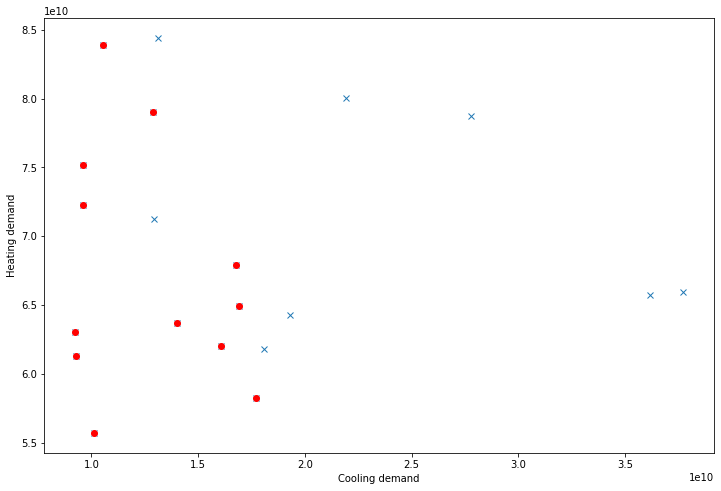

In [27]:
optres = results.loc[
    results["pareto-optimal"] == True, :
]  # Get only the optimal results
plt.figure(figsize=(12, 8))
plt.plot(
    results["DistrictCooling:Facility"], results["DistrictHeating:Facility"], "x"
)  # Plot all results in the background as blue crosses
plt.plot(
    optres["DistrictCooling:Facility"], optres["DistrictHeating:Facility"], "ro"
)  # Plot optimal results in red
plt.xlabel("Cooling demand")
plt.ylabel("Heating demand")

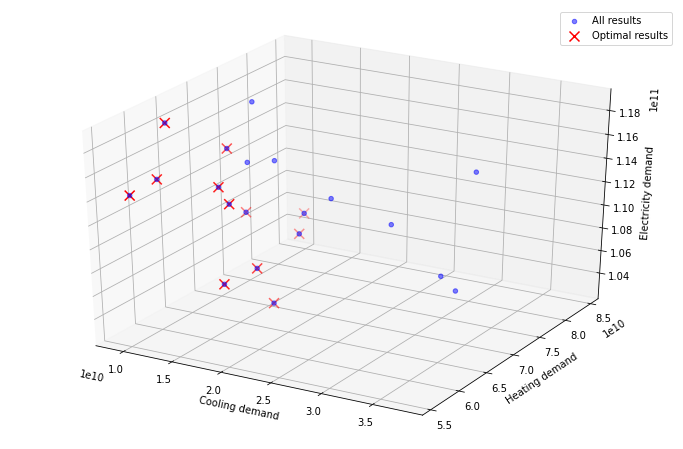

In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Get only the optimal results
optres = results.loc[results["pareto-optimal"] == True, :]

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot all results in the background as blue crosses
ax.scatter(
    results["DistrictCooling:Facility"],
    results["DistrictHeating:Facility"],
    results["Electricity:Facility"],
    c='blue', label='All results', alpha=0.5
)

# Plot optimal results in red
ax.scatter(
    optres["DistrictCooling:Facility"],
    optres["DistrictHeating:Facility"],
    optres["Electricity:Facility"],
    c='red', label='Optimal results', marker='x', s=100
)

# Add labels and legend
ax.set_xlabel("Cooling demand")
ax.set_ylabel("Heating demand")
ax.set_zlabel("Electricity demand")
ax.legend()

# Show the plot
plt.show()

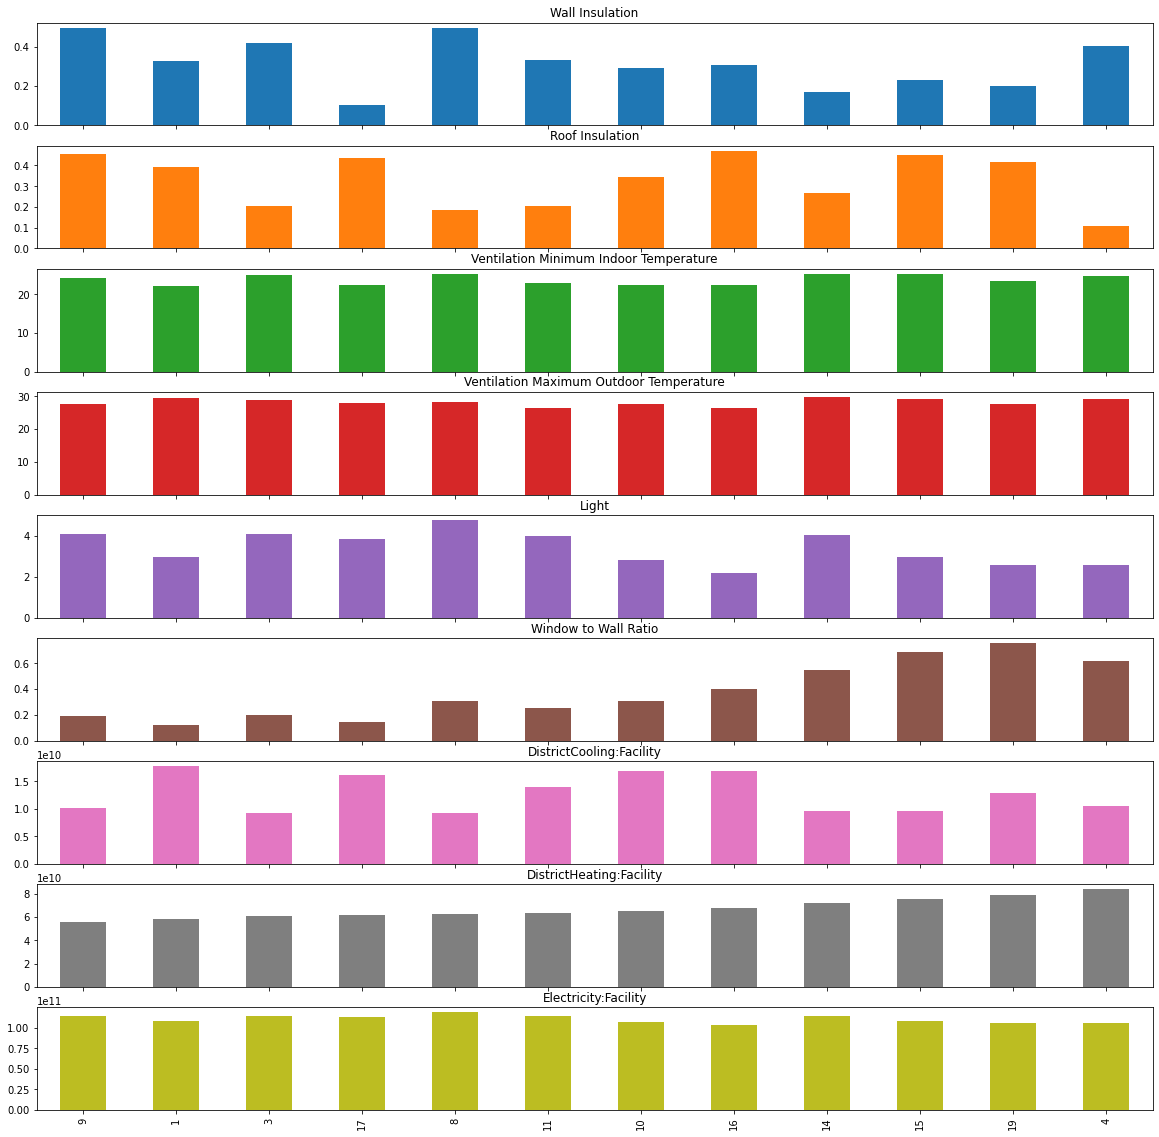

In [21]:
optres = optres.sort_values("DistrictHeating:Facility")  # Sort by the first objective
optresplot = optres.drop(columns="violation")  # Remove the constraint violation column
ax = optresplot.plot.bar(
    subplots=True, legend=None, figsize=(20, 20)
)  # Plot the variable values of each of the optimal solutions

In [74]:
evaluator_costrain = EvaluatorEP(
    EPProblem(
        parameters,
        objectives,
        constraints=["CO2:Facility"],
        constraint_bounds=["<=800"],
    ),
    idf,
    out_dir="outputdir"
)

In [75]:
results_costrain = NSGAII(evaluator, evaluations=1, population_size=10)

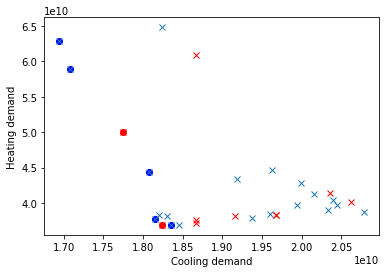

In [79]:
optres_costrain = results_costrain.loc[results_costrain["pareto-optimal"] == True, :]
plt.plot(
    optres["DistrictCooling:Facility"], optres["DistrictHeating:Facility"], "bo"
)  # Plot first optimal results in blue
plt.plot(
    optres_costrain["DistrictCooling:Facility"], optres_costrain["DistrictHeating:Facility"], "ro"
)  # Plot second optimal results in red

plt.plot(
    results["DistrictCooling:Facility"], results["DistrictHeating:Facility"], "x"
) 
plt.plot(
    results_costrain["DistrictCooling:Facility"], results_costrain["DistrictHeating:Facility"], "rx"
) 
plt.xlabel("Cooling demand")
plt.ylabel("Heating demand")
plt.show()

In [22]:
features = list(samples.columns)
print(features)
print(objectives)

['Wall Insulation', 'Roof Insulation', 'Ventilation Minimum Indoor Temperature', 'Ventilation Maximum Outdoor Temperature', 'Light', 'Window to Wall Ratio']
['DistrictCooling:Facility', 'DistrictHeating:Facility', 'Electricity:Facility']


In [198]:
import plotly
plotly.offline.init_notebook_mode(connected=True)

In [202]:
import plotly.express as px
fig = px.parallel_coordinates(results, color="DistrictCooling:Facility", dimensions=features+objectives,
                             color_continuous_scale=px.colors.diverging.Tealrose)
fig.show()

ValueError: Unable to coerce to Series, length must be 6: given 3

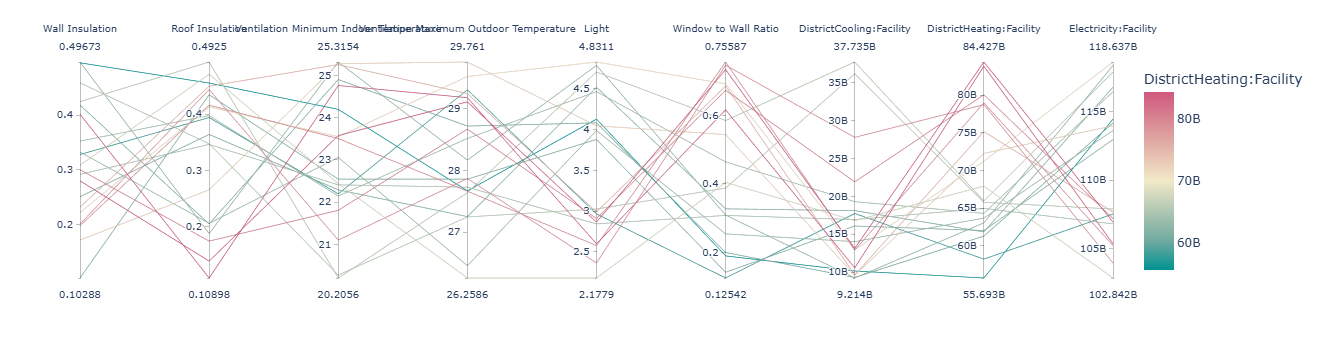

In [25]:
fig = px.parallel_coordinates(results, color="DistrictHeating:Facility", dimensions=features+objectives,
                             color_continuous_scale=px.colors.diverging.Tealrose)
fig.show()

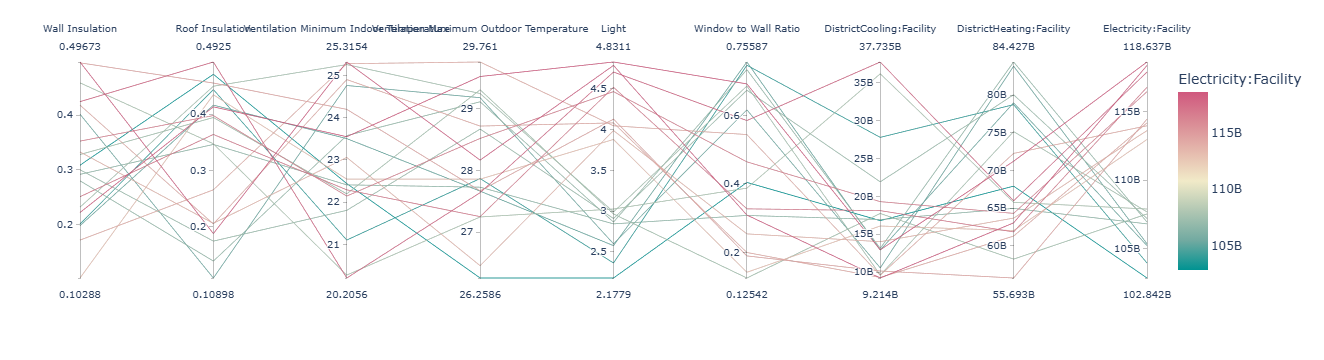

In [26]:
fig = px.parallel_coordinates(results, color="Electricity:Facility", dimensions=features+objectives,
                             color_continuous_scale=px.colors.diverging.Tealrose)
fig.show()